In [ ]:
#wrangling data

In [1]:
import rasterio as rio
import rasterio.mask
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import copy
import sys
import rasterio as rio
from rasterio.plot import show

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch as mpatches  #for plotting categorical map legend

import plotly.graph_objects as go   #for sankey diagram

import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np

from sklearn import metrics  #for confusion matrix
from rasterstats import zonal_stats
import rasterio as rio
from rasterio.plot import show

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 
from matplotlib.patches import Patch  #for plotting categorical map legend

import plotly.graph_objects as go   #for sankey diagram

import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np

from sklearn import metrics  #for confusion matrix
from rasterstats import zonal_stats
import matplotlib as mpl
import numpy as np
import geopandas as gpd
import pandas as pd
import os
import urllib
import zipfile
import re
from descartes import PolygonPatch
from pysal.model import mgwr
import pysal.lib
import libpysal as ps
from libpysal.weights.contiguity import Queen
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
# conda install mgwr
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
import warnings
#warnings.filterwarnings("ignore")

   #for plotting
import statsmodels.api as sm      #for regression modelling
from scipy import stats           #for kendal tau
from sklearn import linear_model  #for cross-validation
from sklearn import model_selection

In [2]:
BAU = rio.open("Geospatial_datasets/BAU_2018-2030.tif")
GOV = rio.open("Geospatial_datasets/GOV_2018-2030.tif")

In [3]:
print(type(BAU))

<class 'rasterio.io.DatasetReader'>


In [4]:
BAU.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 1391,
 'height': 1868,
 'count': 1,
 'crs': CRS.from_epsg(32618),
 'transform': Affine(1000.0, 0.0, 40680.9589,
        0.0, -1000.0, 1393868.2617)}

In [5]:
GOV.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 1391,
 'height': 1868,
 'count': 1,
 'crs': CRS.from_epsg(32618),
 'transform': Affine(1000.0, 0.0, 40680.9589,
        0.0, -1000.0, 1393868.2617)}

In [6]:
shapefile = gpd.read_file('col-administrative-divisions-shapefiles/col_admbnda_adm1_mgn_20200416.shp')

In [7]:
print(shapefile.crs)

epsg:4326


<AxesSubplot: >

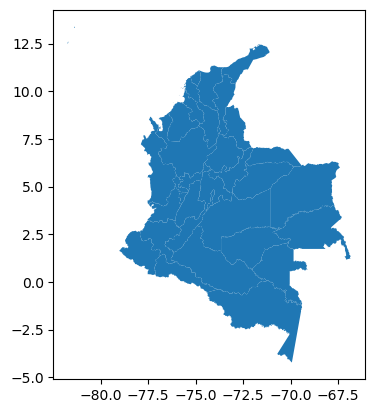

In [8]:
shapefile.plot()

In [9]:
shapefile_osbg  = shapefile.to_crs({'init': 'epsg:32618'})

/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot: >

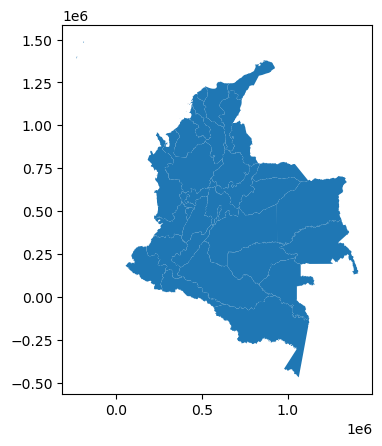

In [10]:
shapefile_osbg.plot()

In [11]:
shapefile_osbg.tail()

ADM1_ES ADM1_PCODE ADM1_REF ADM1ALT1ES ADM1ALT2ES   ADM0_ES  \
28            Sucre       CO70     None       None       None  Colombia   
29           Tolima       CO73     None       None       None  Colombia   
30  Valle del Cauca       CO76     None       None       None  Colombia   
31           Vaupés       CO97   Vaupes       None       None  Colombia   
32          Vichada       CO99     None       None       None  Colombia   

   ADM0_PCODE        date     validOn validTo  Shape_Leng  Shape_Area  \
28         CO  2018-01-01  2020-04-16    None    8.570869    0.870810   
29         CO  2018-01-01  2020-04-16    None    9.549726    1.965027   
30         CO  2018-01-01  2020-04-16    None   12.650870    1.679487   
31         CO  2018-01-01  2020-04-16    None   20.129834    4.313810   
32         CO  2018-01-01  2020-04-16    None   17.292613    8.100680   

                                             geometry  
28  POLYGON ((442675.131 1115593.999, 441153.726 1...  
29  POLYGON ((519751.826 587675.555, 519771.605 58...  
30  MULTIPOLYGON (((251507.405 446944.639, 251546....  
31  POLYGON ((1044406.152 230759.805, 1044463.504 ...  
32  POLYGON ((1297319.091 704588.518, 1297349.032 ...

In [12]:
shapefile['coords'] = shapefile['geometry'].apply(lambda x: x.representative_point().coords[:])
shapefile['coords'] = [coords[0] for coords in shapefile['coords']]

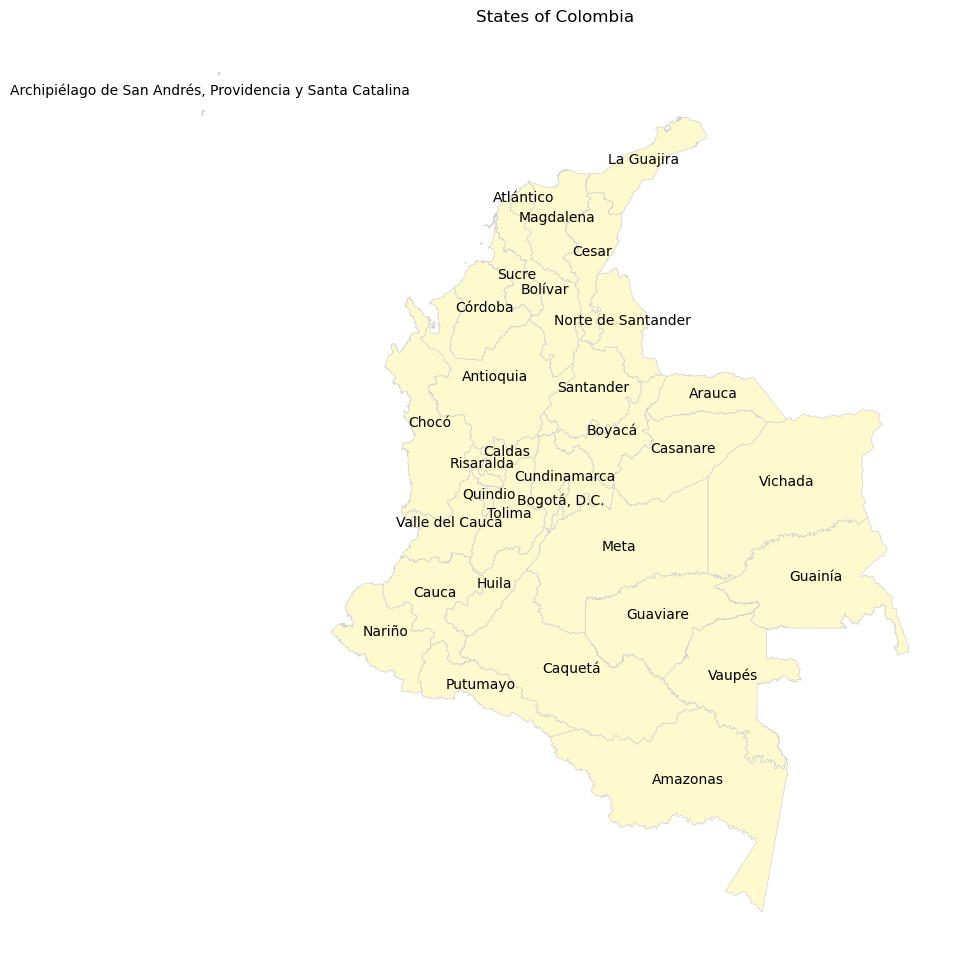

In [13]:
ax = shapefile.plot(figsize = (15, 12), color = "lemonchiffon", edgecolor = "lightgrey", linewidth = 0.5)
shapefile.apply(lambda x: ax.annotate(text=x['ADM1_ES'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
ax.set_axis_off()
ax.set_title("States of Colombia")

plt.savefig("shape.png")

In [14]:
shapefile_osbg.to_file("shapefile_state.geojson", driver='GeoJSON')

/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [15]:
BAU.shape

(1868, 1391)

In [16]:
GOV.shape

(1868, 1391)

In [17]:
print(BAU.bounds)

BoundingBox(left=40680.9589, bottom=-474131.7383000001, right=1431680.9589, top=1393868.2617)


In [18]:
#calculate horizontal resolution (right coord - left coord) / count cells
(BAU.bounds[2] - BAU.bounds[0]) / BAU.width

1000.0

In [19]:
BAU_np = BAU.read()

In [20]:
print(type(BAU_np))

<class 'numpy.ndarray'>


In [21]:
print(BAU_np.shape)

(1, 1868, 1391)


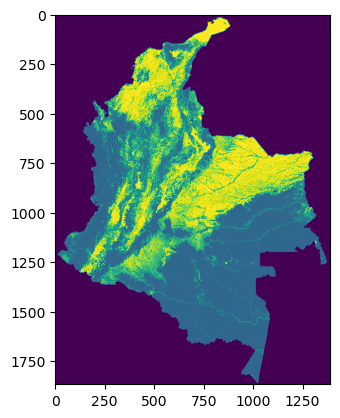

<AxesSubplot: >

In [22]:
show(BAU_np, cmap='viridis')

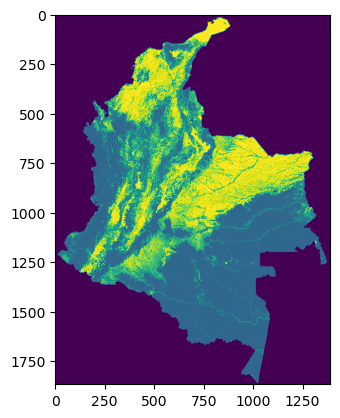

In [23]:
plt.imshow(BAU_np[0], cmap='viridis')

In [24]:
BAU_2D = BAU.read(1)

In [25]:
print(BAU_2D.shape)

(1868, 1391)


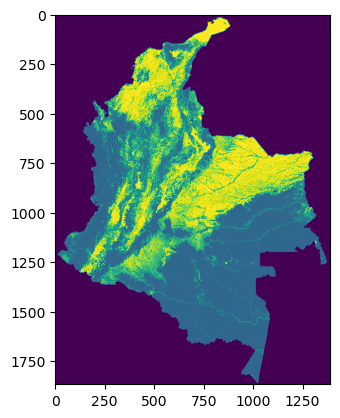

In [26]:
plt.imshow(BAU_2D, cmap='viridis')

In [27]:
GOV_2D = GOV.read(1) 

In [28]:
print(type(GOV))
print(type(GOV_2D))
print(GOV_2D.shape)

<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
(1868, 1391)


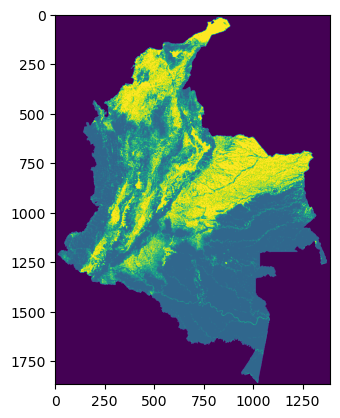

In [29]:
plt.imshow(GOV_2D, cmap='viridis')

In [30]:
lc6_colors = [ "peru", "darkseagreen", "honeydew",]
lc6_cmap = ListedColormap(lc6_colors)   
print(type(lc6_cmap))

<class 'matplotlib.colors.ListedColormap'>


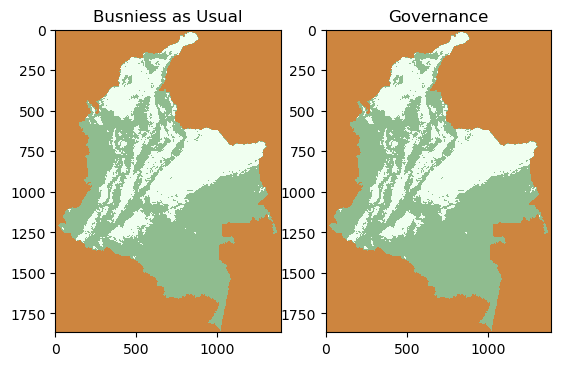

In [31]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(BAU_2D, cmap=lc6_cmap)
axs[1].imshow(GOV_2D, cmap=lc6_cmap)

axs[0].set_title("Busniess as Usual")
axs[1].set_title("Governance")

plt.show()

In [32]:
lc6_names = [
    "Border",
     "Forest",
    "No forest",
]

# use zip to combine two lists into a dict
legend_labels = dict(zip(lc6_colors, lc6_names))

print(legend_labels)

{'peru': 'Border', 'darkseagreen': 'Forest', 'honeydew': 'No forest'}


In [33]:
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

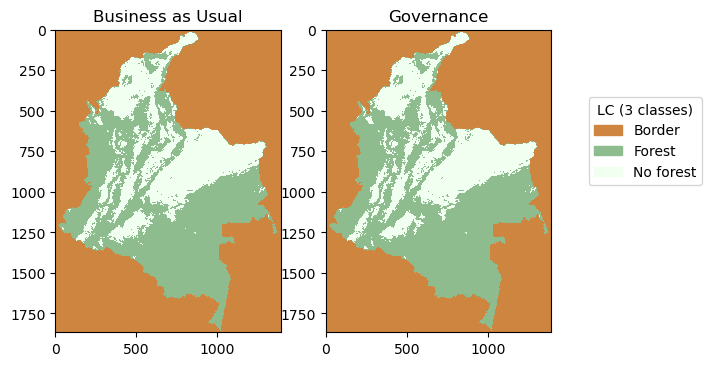

In [34]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(BAU_2D, cmap=lc6_cmap)
axs[1].imshow(GOV_2D, cmap=lc6_cmap)

axs[0].set_title("Business as Usual")
axs[1].set_title("Governance")

#add legend
axs[1].legend(
    handles=patches,
    bbox_to_anchor=(1.7, 0.8),  #positioning of the legend, often need to play with this
    facecolor="white",
    title='LC (3 classes)')

plt.show()

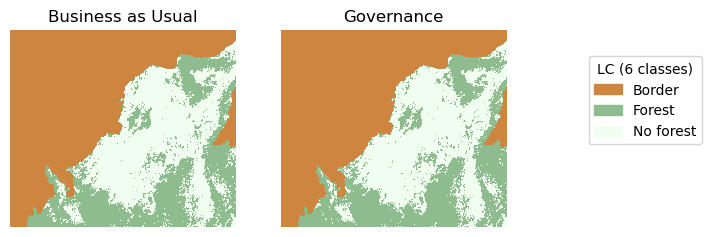

In [35]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(BAU_2D[75:600,100:700], cmap=lc6_cmap)
axs[1].imshow(GOV_2D[75:600,100:700], cmap=lc6_cmap)

axs[0].set_title("Business as Usual")
axs[1].set_title("Governance")

axs[1].legend(handles=patches,
          bbox_to_anchor=(1.9, 0.9),  #positioning of the legend, often need to play with this
          facecolor="white",
             title='LC (6 classes)')


axs[0].set_axis_off()
axs[1].set_axis_off()

plt.savefig('zoominBAUGOV2d.png')
plt.show()

In [36]:
BAU_50 = rio.open("Geospatial_datasets/BAU_2030-2050.tif")
GOV_50 = rio.open("Geospatial_datasets/GOV_2030-2050.tif")

In [37]:
BAU_50_2D = BAU_50.read(1)

In [38]:
print(BAU_50_2D.shape)

(1868, 1391)


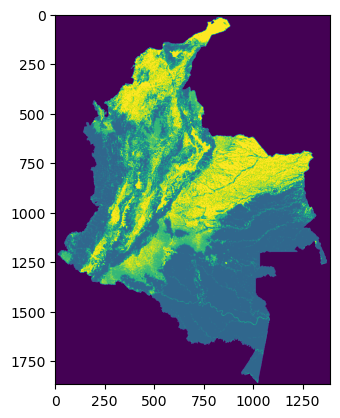

In [39]:
plt.imshow(BAU_50_2D, cmap='viridis')

In [40]:
GOV_50_2D = GOV_50.read(1) 

In [41]:
print(GOV_50_2D.shape)

(1868, 1391)


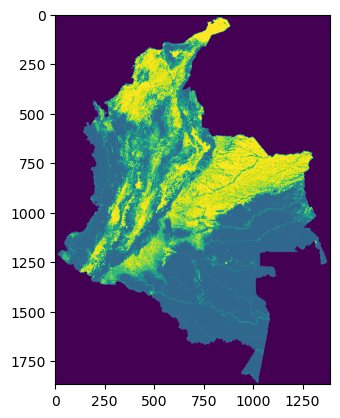

In [42]:
plt.imshow(GOV_50_2D, cmap='viridis')

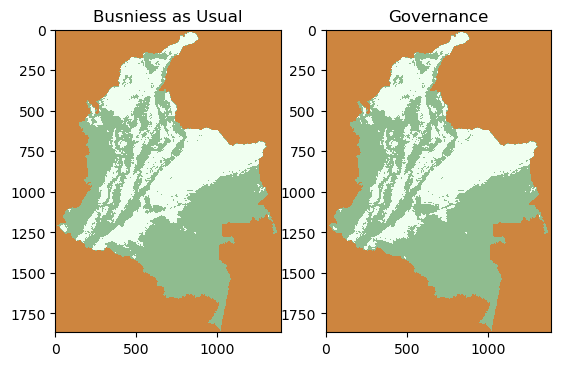

In [43]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(BAU_50_2D, cmap=lc6_cmap)
axs[1].imshow(GOV_50_2D, cmap=lc6_cmap)

axs[0].set_title("Busniess as Usual")
axs[1].set_title("Governance")

plt.show()

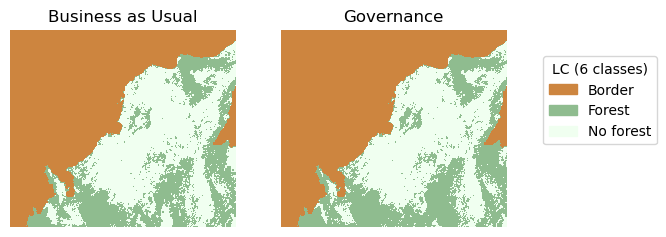

In [44]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(BAU_50_2D[75:600,100:700], cmap=lc6_cmap)
axs[1].imshow(GOV_50_2D[75:600,100:700], cmap=lc6_cmap)

axs[0].set_title("Business as Usual")
axs[1].set_title("Governance")

axs[1].legend(handles=patches,
          bbox_to_anchor=(1.7, 0.9),  #positioning of the legend, often need to play with this
          facecolor="white",
             title='LC (6 classes)')


axs[0].set_axis_off()
axs[1].set_axis_off()

plt.savefig('zoominBAUGOV2d50.png')
plt.show()

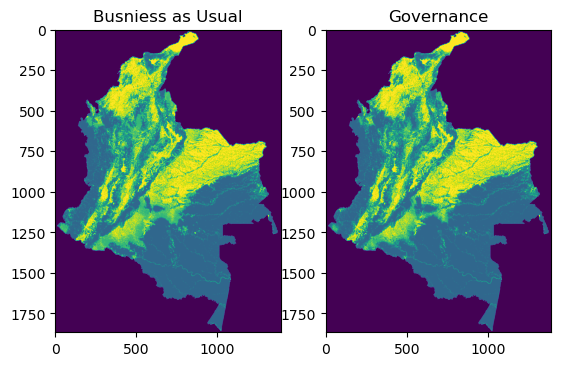

In [45]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(BAU_50_2D, cmap='viridis')
axs[1].imshow(GOV_50_2D, cmap='viridis')

axs[0].set_title("Busniess as Usual")
axs[1].set_title("Governance")

plt.show()

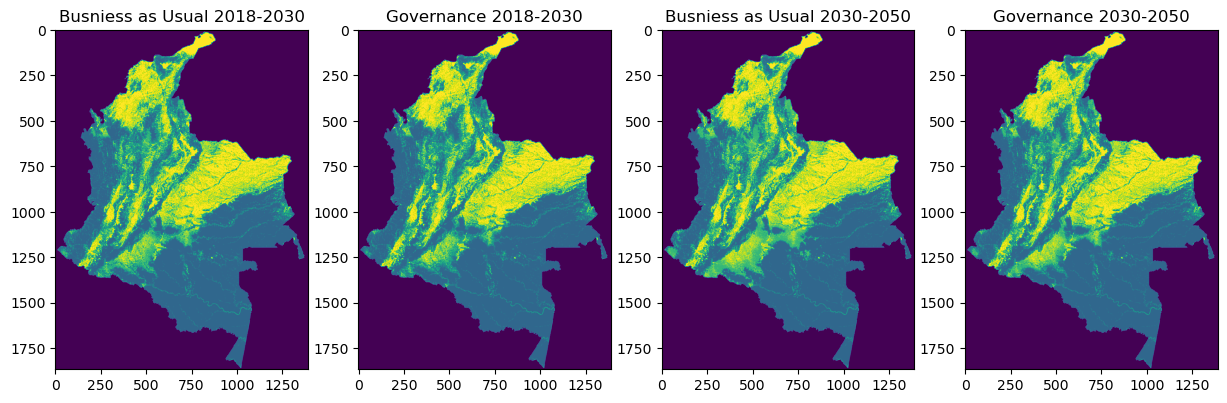

In [46]:
fig, axs = plt.subplots(1, 4)
fig.set_figheight(15)
fig.set_figwidth(15)

axs[0].imshow(BAU_2D, cmap='viridis')
axs[1].imshow(GOV_2D, cmap='viridis')
axs[2].imshow(BAU_50_2D, cmap='viridis')
axs[3].imshow(GOV_50_2D, cmap='viridis')

axs[0].set_title("Busniess as Usual 2018-2030")
axs[1].set_title("Governance 2018-2030")
axs[2].set_title("Busniess as Usual 2030-2050")
axs[3].set_title("Governance 2030-2050")

plt.show()

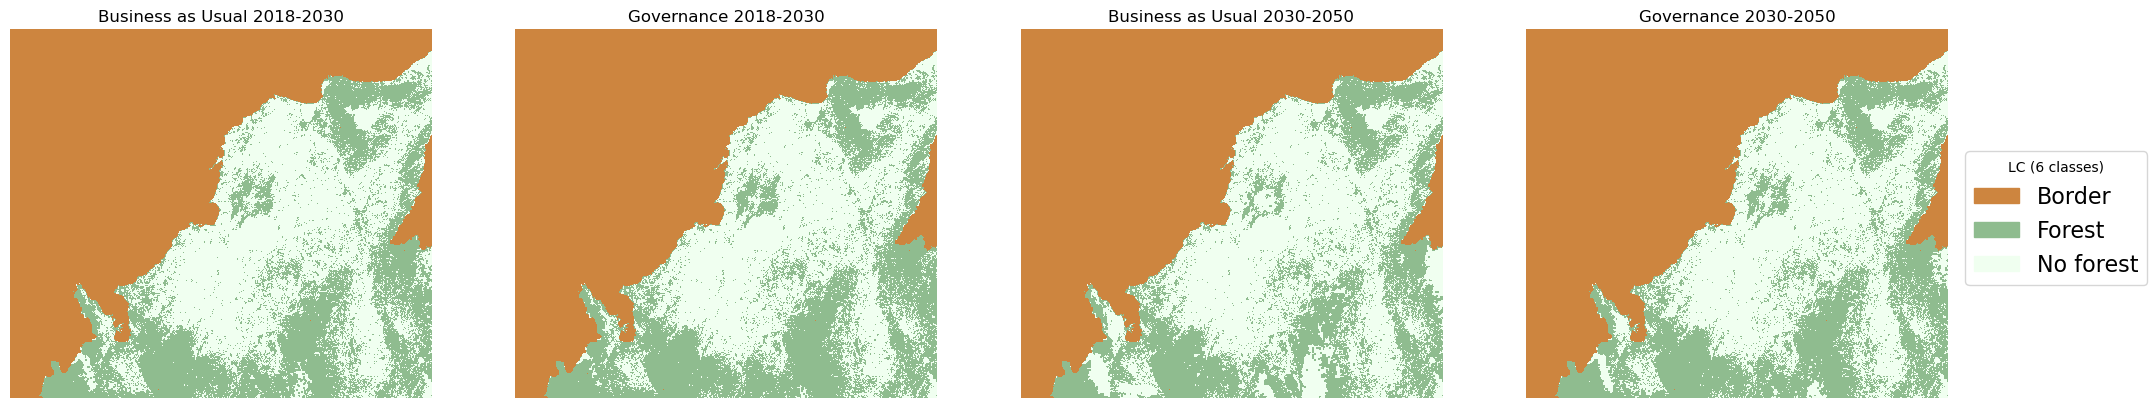

In [47]:
fig, axs = plt.subplots(1, 4, figsize = (25,16))

axs[0].imshow(BAU_2D[75:600,100:700], cmap=lc6_cmap)
axs[1].imshow(GOV_2D[75:600,100:700], cmap=lc6_cmap)
axs[2].imshow(BAU_50_2D[75:600,100:700], cmap=lc6_cmap)
axs[3].imshow(GOV_50_2D[75:600,100:700], cmap=lc6_cmap)

axs[0].set_title("Business as Usual 2018-2030")
axs[1].set_title("Governance 2018-2030")
axs[2].set_title("Business as Usual 2030-2050")
axs[3].set_title("Governance 2030-2050")

axs[1].legend(handles=patches,
          bbox_to_anchor=(3.9, 0.7),  #positioning of the legend, often need to play with this
          facecolor="white",
              fontsize=16,
             title='LC (6 classes)')


axs[0].set_axis_off()
axs[1].set_axis_off()
axs[2].set_axis_off()
axs[3].set_axis_off()

plt.savefig('zoominBAUGOV2dall.png')
plt.show()

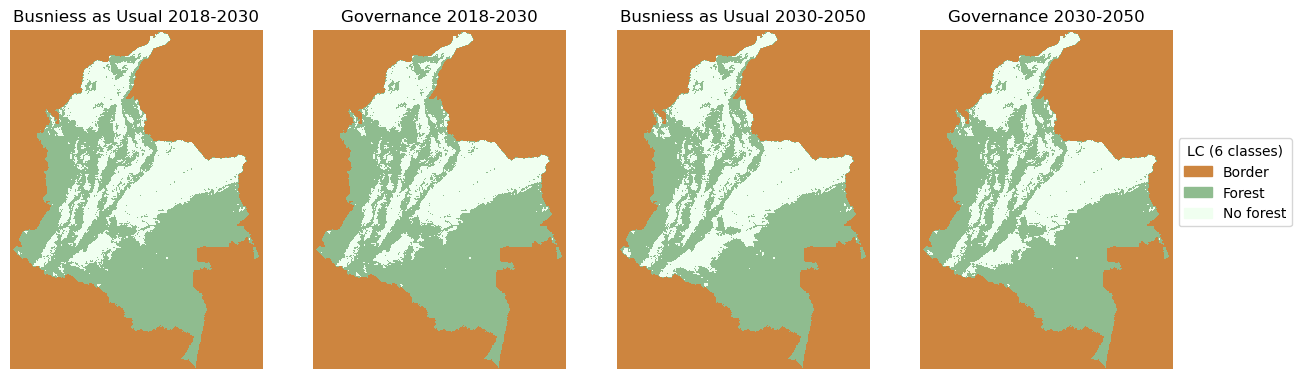

In [48]:
fig, axs = plt.subplots(1, 4)
fig.set_figheight(15)
fig.set_figwidth(15)

axs[0].imshow(BAU_2D, cmap=lc6_cmap)
axs[1].imshow(GOV_2D, cmap=lc6_cmap)
axs[2].imshow(BAU_50_2D, cmap=lc6_cmap)
axs[3].imshow(GOV_50_2D, cmap=lc6_cmap)

axs[0].set_title("Busniess as Usual 2018-2030")
axs[1].set_title("Governance 2018-2030")
axs[2].set_title("Busniess as Usual 2030-2050")
axs[3].set_title("Governance 2030-2050")

axs[1].legend(handles=patches,
          bbox_to_anchor=(3.9, 0.7),  
          facecolor="white",
              fontsize=10,
             title='LC (6 classes)')

axs[0].set_axis_off()
axs[1].set_axis_off()
axs[2].set_axis_off()
axs[3].set_axis_off()


plt.savefig("dif.png")

plt.show()

In [49]:
unique, counts = np.unique(BAU_2D, return_counts=True)  #get the unique values and counts
counts_BAU_2D = dict(zip(unique, counts))                         #combine them into a dict for easier viewing

unique, counts = np.unique(GOV_2D, return_counts=True)
counts_GOV_2D = dict(zip(unique, counts))

print(counts_BAU_2D)
print('\n')
print(counts_GOV_2D)

{0: 1459412, 1: 694938, 2: 67864, 3: 376174}


{0: 1459412, 1: 714034, 2: 48768, 3: 376174}


In [50]:
unique, counts = np.unique(BAU_50_2D, return_counts=True)  #get the unique values and counts
counts_BAU_50_2D = dict(zip(unique, counts))                         #combine them into a dict for easier viewing

unique, counts = np.unique(GOV_50_2D, return_counts=True)
counts_GOV_50_2D = dict(zip(unique, counts))

print(counts_BAU_50_2D)
print('\n')
print(counts_GOV_50_2D)

{0: 1459412, 1: 654394, 2: 108408, 3: 376174}


{0: 1459412, 1: 692973, 2: 69829, 3: 376174}


In [51]:
counts_df = pd.DataFrame.from_dict(counts_BAU_2D,orient="index") #tell pandas to use keys as indexes 
print(type(counts_df))
print(counts_df)

<class 'pandas.core.frame.DataFrame'>
         0
0  1459412
1   694938
2    67864
3   376174


In [52]:
counts_df = pd.DataFrame.from_dict([counts_BAU_2D,counts_GOV_2D, counts_BAU_50_2D, counts_GOV_50_2D])
print(type(counts_df))
print(counts_df)

<class 'pandas.core.frame.DataFrame'>
         0       1       2       3
0  1459412  694938   67864  376174
1  1459412  714034   48768  376174
2  1459412  654394  108408  376174
3  1459412  692973   69829  376174


In [53]:
lc6_names = [
    "Total Area",
     "Forest",
    "Deforestation",
    "No Forest"
]

In [54]:
lclabs = dict(zip(np.arange(0,4).tolist(), lc6_names))
lclabs

{0: 'Total Area', 1: 'Forest', 2: 'Deforestation', 3: 'No Forest'}

In [55]:
counts_df = pd.DataFrame.from_dict([lclabs, counts_BAU_2D,counts_GOV_2D, counts_BAU_50_2D, counts_GOV_50_2D])
print(type(counts_df))
print(counts_df)

<class 'pandas.core.frame.DataFrame'>
            0       1              2          3
0  Total Area  Forest  Deforestation  No Forest
1     1459412  694938          67864     376174
2     1459412  714034          48768     376174
3     1459412  654394         108408     376174
4     1459412  692973          69829     376174


In [56]:
counts_df = pd.DataFrame.from_dict([lclabs,counts_BAU_2D,counts_GOV_2D, counts_BAU_50_2D, counts_GOV_50_2D]).T
print(type(counts_df))
print(counts_df)

<class 'pandas.core.frame.DataFrame'>
               0        1        2        3        4
0     Total Area  1459412  1459412  1459412  1459412
1         Forest   694938   714034   654394   692973
2  Deforestation    67864    48768   108408    69829
3      No Forest   376174   376174   376174   376174


In [57]:
counts_df = pd.DataFrame.from_dict([lclabs,counts_BAU_2D,counts_GOV_2D, counts_BAU_50_2D, counts_GOV_50_2D]).T
counts_df.columns = ['Land Cover', 'BAU 2018-30', 'GOV 2018-30', 'BAU 2030-50', 'GOV 2030-50']
counts_df

Land Cover BAU 2018-30 GOV 2018-30 BAU 2030-50 GOV 2030-50
0     Total Area     1459412     1459412     1459412     1459412
1         Forest      694938      714034      654394      692973
2  Deforestation       67864       48768      108408       69829
3      No Forest      376174      376174      376174      376174

In [58]:
counts_df_long = pd.melt(counts_df, id_vars=['Land Cover'], value_vars=['Land Cover', 'BAU 2018-30', 'GOV 2018-30', 'BAU 2030-50', 'GOV 2030-50'])
counts_df_long

Land Cover     variable    value
0      Total Area  BAU 2018-30  1459412
1          Forest  BAU 2018-30   694938
2   Deforestation  BAU 2018-30    67864
3       No Forest  BAU 2018-30   376174
4      Total Area  GOV 2018-30  1459412
5          Forest  GOV 2018-30   714034
6   Deforestation  GOV 2018-30    48768
7       No Forest  GOV 2018-30   376174
8      Total Area  BAU 2030-50  1459412
9          Forest  BAU 2030-50   654394
10  Deforestation  BAU 2030-50   108408
11      No Forest  BAU 2030-50   376174
12     Total Area  GOV 2030-50  1459412
13         Forest  GOV 2030-50   692973
14  Deforestation  GOV 2030-50    69829
15      No Forest  GOV 2030-50   376174

In [59]:
counts_df_long.rename(columns={'variable':'Years and outcome','value':'cells'}, inplace = True)
counts_df_long

Land Cover Years and outcome    cells
0      Total Area       BAU 2018-30  1459412
1          Forest       BAU 2018-30   694938
2   Deforestation       BAU 2018-30    67864
3       No Forest       BAU 2018-30   376174
4      Total Area       GOV 2018-30  1459412
5          Forest       GOV 2018-30   714034
6   Deforestation       GOV 2018-30    48768
7       No Forest       GOV 2018-30   376174
8      Total Area       BAU 2030-50  1459412
9          Forest       BAU 2030-50   654394
10  Deforestation       BAU 2030-50   108408
11      No Forest       BAU 2030-50   376174
12     Total Area       GOV 2030-50  1459412
13         Forest       GOV 2030-50   692973
14  Deforestation       GOV 2030-50    69829
15      No Forest       GOV 2030-50   376174

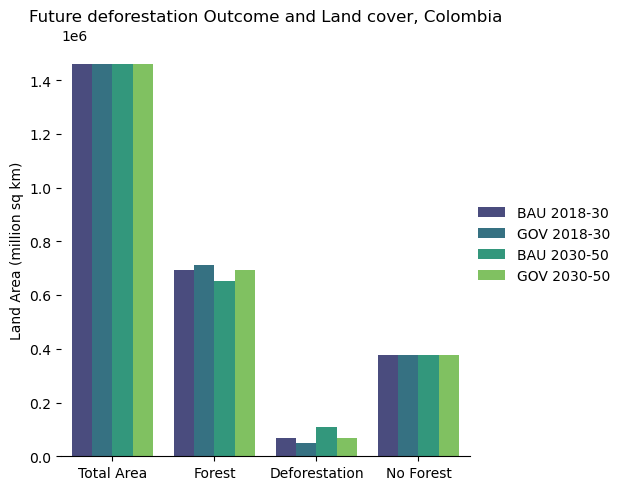

In [60]:
# Draw a nested barplot by land cover and year
g = sns.catplot(
    data=counts_df_long[counts_df_long['Land Cover'] != 'No Data'],   #don't plot NoData pixels!
    kind="bar",
    x='Land Cover', y='cells', 
    hue="Years and outcome",
    palette="viridis"
)
g.despine(left=True)
g.set_axis_labels("", "Land Area (million sq km)")
g.legend.set_title("")
plt.title("Future deforestation Outcome and Land cover, Colombia")
plt.show()

In [61]:
counts_df_long.drop([0,3,4,7,8,11,12,15], axis=0, inplace=True)

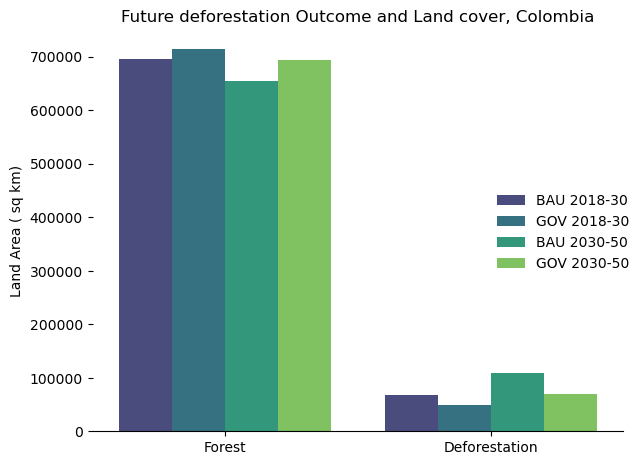

In [62]:
g = sns.catplot(
    data=counts_df_long[counts_df_long['Land Cover'] != 'No Data'],   #don't plot NoData pixels!
    kind="bar",
    x='Land Cover', y='cells', 
    hue="Years and outcome",
    palette="viridis"
)
g.despine(left=True)
g.set_axis_labels("", "Land Area ( sq km)")
g.legend.set_title("")
plt.title("Future deforestation Outcome and Land cover, Colombia")
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.savefig("Future_def.png")
plt.show()

In [63]:
counts_df['Diffc-2018-30'] = counts_df['BAU 2018-30'] - counts_df['GOV 2018-30']
counts_df

Land Cover BAU 2018-30 GOV 2018-30 BAU 2030-50 GOV 2030-50 Diffc-2018-30
0     Total Area     1459412     1459412     1459412     1459412             0
1         Forest      694938      714034      654394      692973        -19096
2  Deforestation       67864       48768      108408       69829         19096
3      No Forest      376174      376174      376174      376174             0

In [64]:
counts_df['Diffc-2030-50'] = counts_df['BAU 2030-50'] - counts_df['GOV 2030-50']
counts_df

Land Cover BAU 2018-30 GOV 2018-30 BAU 2030-50 GOV 2030-50  \
0     Total Area     1459412     1459412     1459412     1459412   
1         Forest      694938      714034      654394      692973   
2  Deforestation       67864       48768      108408       69829   
3      No Forest      376174      376174      376174      376174   

  Diffc-2018-30 Diffc-2030-50  
0             0             0  
1        -19096        -38579  
2         19096         38579  
3             0             0

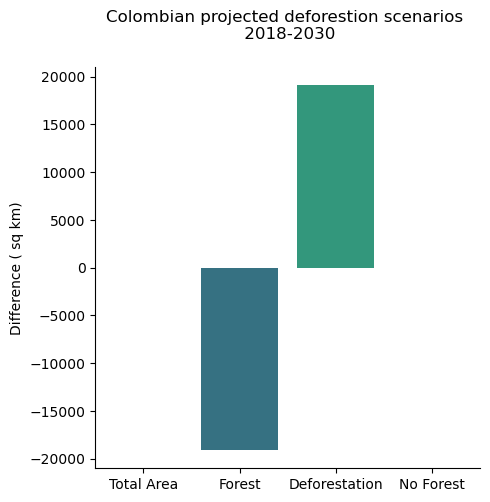

In [65]:
g = sns.catplot(
    data=counts_df[counts_df['Land Cover'] != 'No Data'], 
    kind='bar',
    x='Land Cover', y='Diffc-2018-30',
    palette="viridis"
)
g.despine()
g.set_axis_labels("", "Difference ( sq km)")
plt.title("Colombian projected deforestion scenarios \n 2018-2030", pad=20)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.savefig("Bar_chart_def.png",dpi=600)

plt.show()

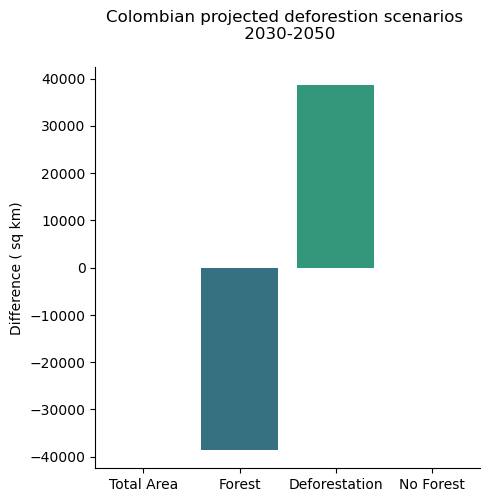

In [66]:
g = sns.catplot(
    data=counts_df[counts_df['Land Cover'] != 'No Data'], 
    kind='bar',
    x='Land Cover', y='Diffc-2030-50',
    palette="viridis"
)
g.despine()
g.set_axis_labels("", "Difference ( sq km)")
plt.title("Colombian projected deforestion scenarios \n 2030-2050", pad=20)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.savefig("Bar_chart_def_50.png",dpi=600)

plt.show()

In [67]:
shapefile.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [68]:
BAU.crs

CRS.from_epsg(32618)

In [69]:
print(BAU.bounds)

BoundingBox(left=40680.9589, bottom=-474131.7383000001, right=1431680.9589, top=1393868.2617)


In [70]:
shapefile.crs =('EPSG:32618')

In [71]:
shapefile.crs

<Derived Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot: >

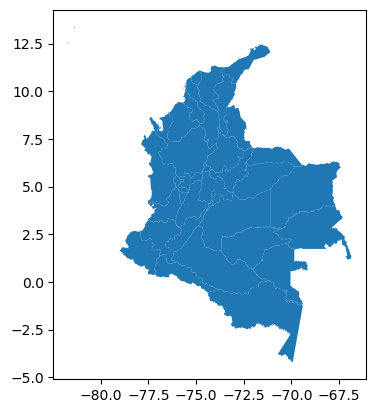

In [72]:
shapefile.plot()

<AxesSubplot: >

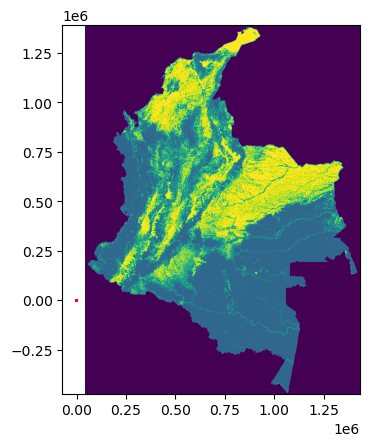

In [73]:
fig,ax1=plt.subplots(1)
show((GOV,1), cmap='viridis',ax=ax1)
shapefile.plot(ax=ax1, facecolor='None', edgecolor='red', linewidth=1.5)

In [74]:
shapefile2 = gpd.read_file('COL_adm/COL_adm1.shp')

In [75]:
shapefile2 = shapefile2.set_geometry('geometry')

In [76]:
shapefile2.head()

ID_0  ISO    NAME_0  ID_1     NAME_1        TYPE_1    ENGTYPE_1 NL_NAME_1  \
0    53  COL  Colombia     1   Amazonas     Comisaría  Commissiary      None   
1    53  COL  Colombia     2  Antioquia  Departamento   Department      None   
2    53  COL  Colombia     3     Arauca   Intendencia   Intendancy      None   
3    53  COL  Colombia     4  Atlántico  Departamento   Department      None   
4    53  COL  Colombia     5    Bolívar  Departamento   Department      None   

  VARNAME_1                                           geometry  
0      None  MULTIPOLYGON (((-69.43138 -1.07847, -69.42712 ...  
1      None  MULTIPOLYGON (((-76.92486 8.21236, -76.92486 8...  
2      None  POLYGON ((-70.68780 7.09091, -70.66744 7.07901...  
3      None  POLYGON ((-74.84764 11.10792, -74.84764 11.107...  
4      None  MULTIPOLYGON (((-75.67486 10.16125, -75.67486 ...

<AxesSubplot: >

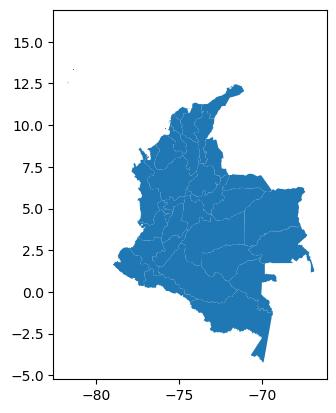

In [77]:
shapefile2.plot()

In [78]:
shapefile2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [79]:
proj_shapefile2 = shapefile2.to_crs({'init':'EPSG:32618'})

/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot: >

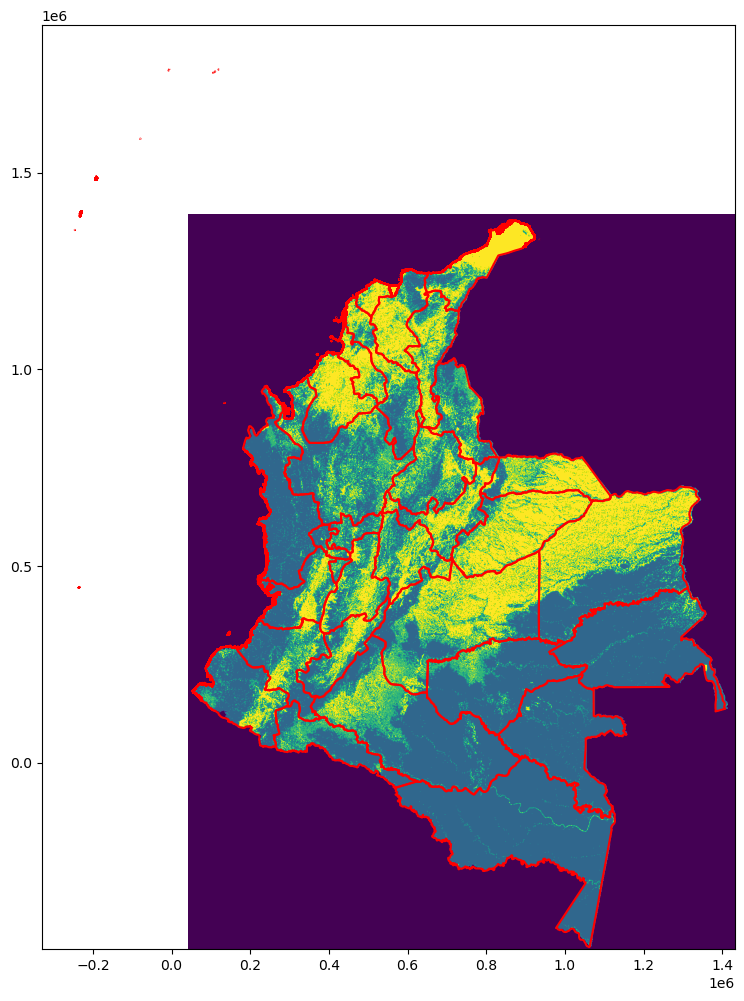

In [80]:
fig,ax1=plt.subplots(1, figsize= (15,12,))
show((BAU,1), cmap='viridis',ax=ax1)
proj_shapefile2.plot(ax=ax1, facecolor='None', edgecolor='red', linewidth=1.5)

In [81]:
Densidad =  gpd.read_file('Coca_data/Densidad.geojson')

<AxesSubplot: >

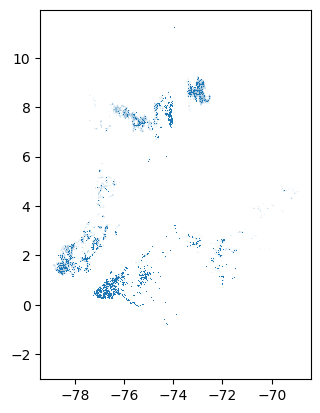

In [82]:
Densidad.plot( legend =True )

In [83]:
Densidad.head()

grilla1     areacoca   ano  \
0   120_93_1_3   2.60999831  2019   
1   131_8_1_15   4.72438176  2019   
2   21_19_3_21   1.48469104  2019   
3    21_29_1_1  11.62505202  2019   
4  140_14_2_24   1.62426884  2019   

                                            geometry  
0  MULTIPOLYGON (((-77.11572 0.37531, -77.10669 0...  
1  MULTIPOLYGON (((-76.64911 0.26709, -76.64020 0...  
2  MULTIPOLYGON (((-72.98920 9.15472, -72.98010 9...  
3  MULTIPOLYGON (((-72.98920 9.14569, -72.98010 9...  
4  MULTIPOLYGON (((-74.27850 -0.74561, -74.26959 ...

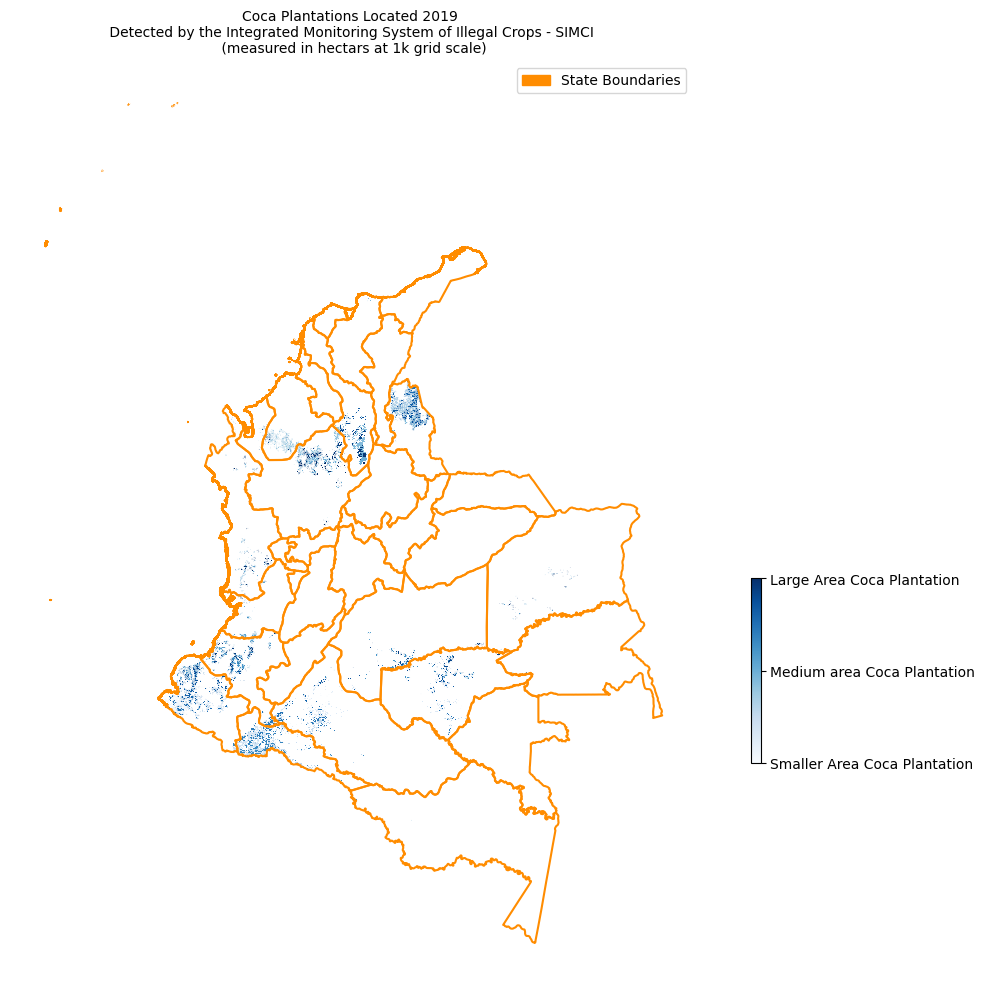

In [84]:
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
import matplotlib.cm
from pylab import *
import numpy as np
from matplotlib import colors
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm

fig,ax1=plt.subplots(1, figsize=(15, 12))
ax1.set_title('Coca Plantations Located 2019 \n Detected by the Integrated Monitoring System of Illegal Crops - SIMCI \n (measured in hectars at 1k grid scale)', fontsize=10)
Densidad.plot(cmap='Blues',ax=ax1)
shapefile2.plot(ax=ax1, facecolor='None', edgecolor='darkorange', linewidth=1.5)
red_patch = mpatches.Patch(color='darkorange', label='State Boundaries')
plt.legend(handles=[red_patch])


cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(),cmap='Blues'), ax=ax1, anchor=(0, 0.3), shrink=0.2) 
m0=0           
m1=1                         
m2=0.5 

cbar.set_ticks([m0,m2,m1])
cbar.set_ticklabels(['Smaller Area Coca Plantation','Medium area Coca Plantation', 'Large Area Coca Plantation'])
ax1.axis('off')

plt.savefig("coca2019orangxcxe.png")

TypeError: show() got an unexpected keyword argument 'cmap'

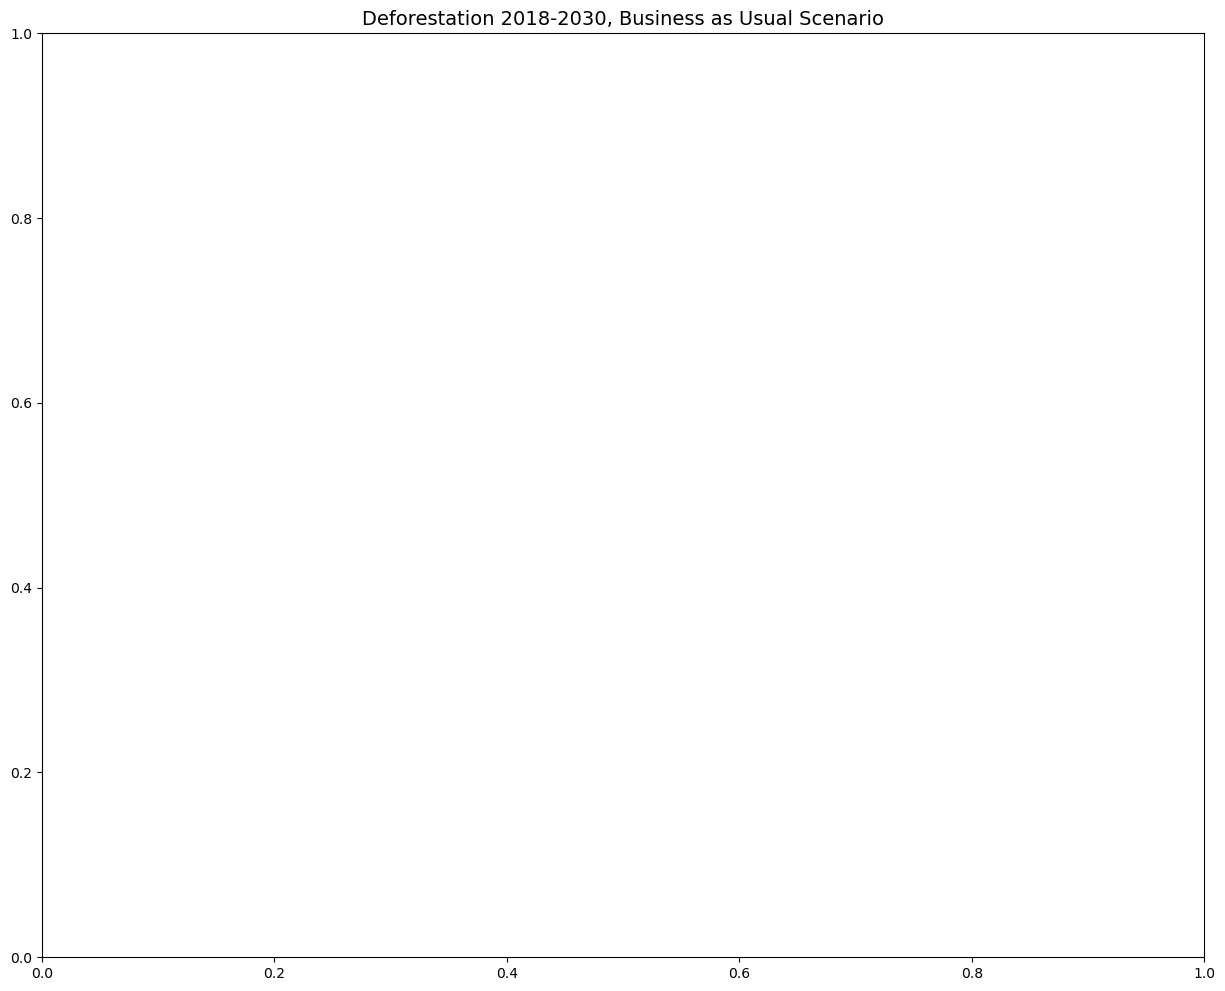

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


fig,ax1=plt.subplots(1, figsize=(15, 12))
ax1.set_title('Deforestation 2018-2030, Business as Usual Scenario', fontsize=14)

show((BAU,1), cmap='RdYlGn_r',ax=ax1)

proj_shapefile2.plot(ax=ax1, facecolor='None', edgecolor='darkgreen', linewidth=1.5)
red_patch = mpatches.Patch(color='darkgreen', label='State Boundaries')
plt.legend(handles=[red_patch])

cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(),cmap='RdYlGn_r'), ax=ax1) 
m0=0            # colorbar min value
m4=1            # colorbar max value
m1=0.25              # colorbar mid value 1
m2=0.5  
m3=0.75# colorbar mid value 2
cbar.set_ticks([m0,m1,m2,m3,m4])
cbar.set_ticklabels(['Not territory','Forest' ,'Rivers/water bodies','Deforestation','No forest'])
ax1.axis('off')


TypeError: show() got an unexpected keyword argument 'cmap'

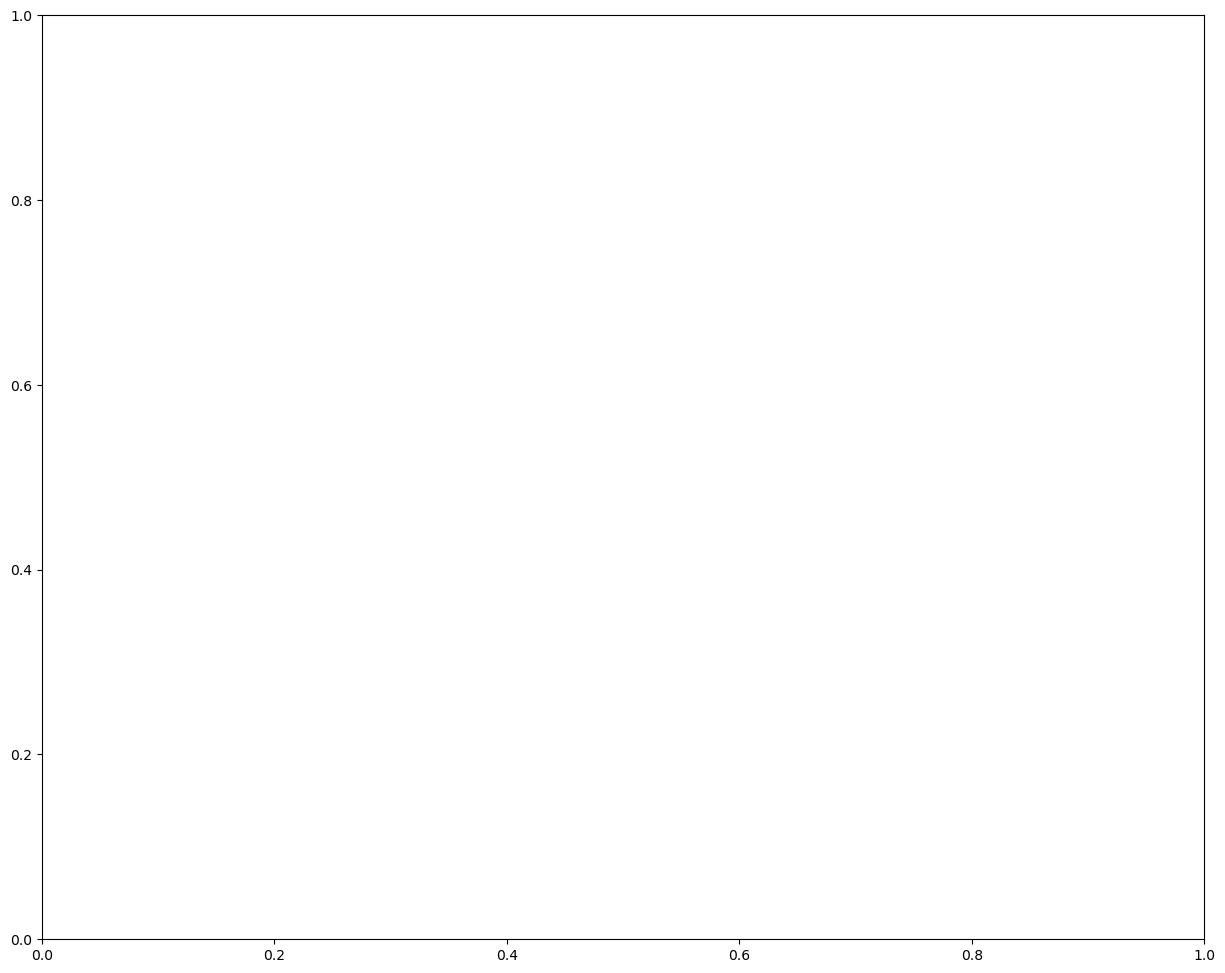

In [106]:

fig,ax1=plt.subplots(1, figsize=(15, 12))

plt.show((GOV,1), cmap='RdYlGn_r',ax=ax1)
proj_shapefile2.plot(ax=ax1, facecolor='None', edgecolor='darkgreen', linewidth=1.5)
ax1.set_title('Deforestation 2018-2030, Governance Scenario', fontsize=14)


red_patch = mpatches.Patch(color='darkgreen', label='State Boundaries')
plt.legend(handles=[red_patch])

cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(), cmap='RdYlGn_r'), ax=ax1) 
m0=0            # colorbar min value
m4=1            # colorbar max value
m1=0.25              # colorbar mid value 1
m2=0.5  
m3=0.75# colorbar mid value 2
cbar.set_ticks([m0,m1,m2,m3,m4])
cbar.set_ticklabels(['Not territory','Forest' ,'Rivers/water bodies','Deforestation','No forest'])
ax1.axis('off')


TypeError: show() got an unexpected keyword argument 'cmap'

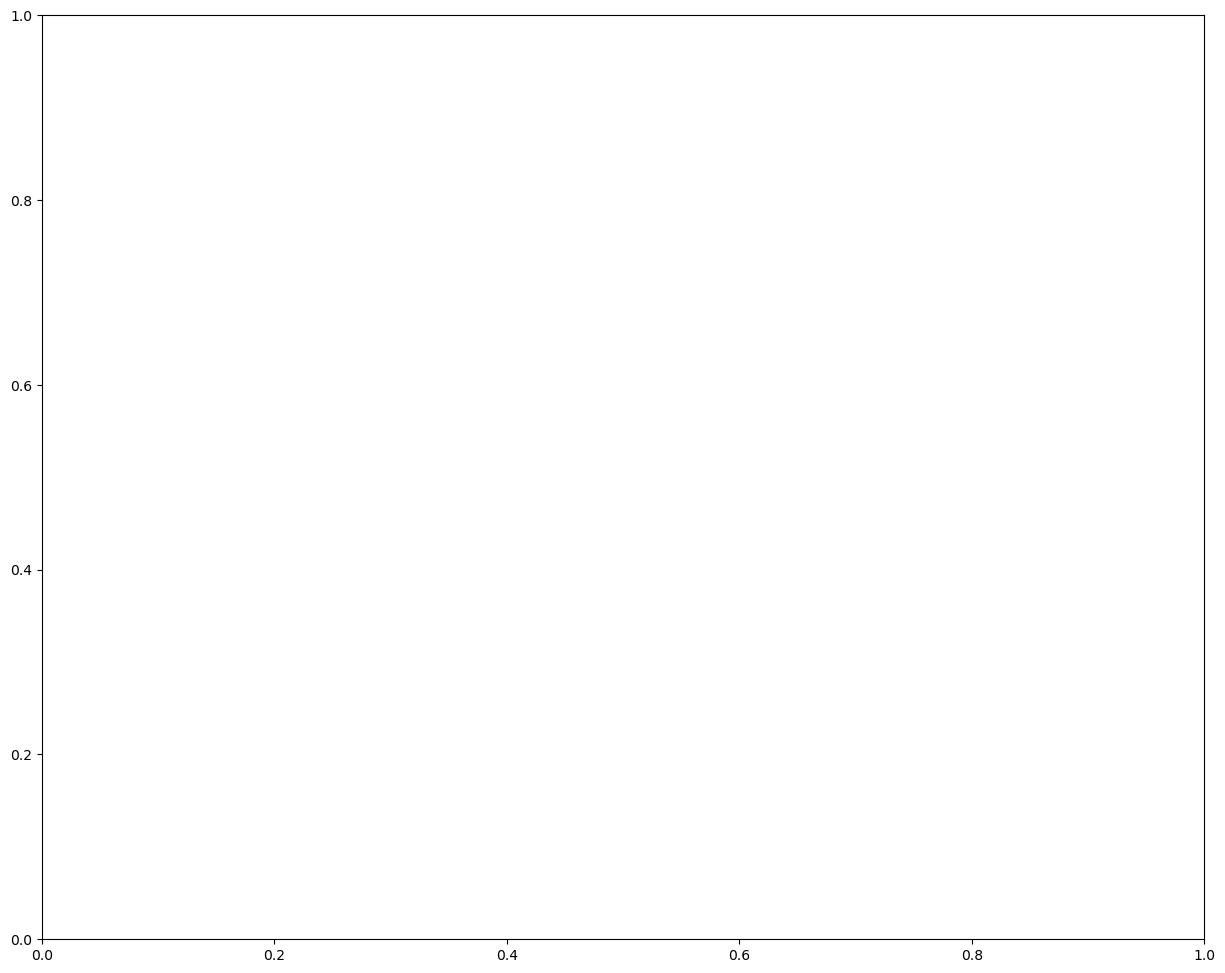

In [107]:
fig,ax1=plt.subplots(1, figsize=(15, 12))
show((BAU_50,1), cmap='RdYlGn_r',ax=ax1)

proj_shapefile2.plot(ax=ax1, facecolor='None', edgecolor='darkgreen', linewidth=1.5)
ax1.set_title('Deforestation 2030-2050, Business as Usual Scenario', fontsize=14)


red_patch = mpatches.Patch(color='darkgreen', label='State Boundaries')
plt.legend(handles=[red_patch])

cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(),cmap='RdYlGn_r'), ax=ax1) 
m0=0            # colorbar min value
m4=1            # colorbar max value
m1=0.25              # colorbar mid value 1
m2=0.5  
m3=0.75# colorbar mid value 2
cbar.set_ticks([m0,m1,m2,m3,m4])
cbar.set_ticklabels(['Not territory','Forest' ,'Rivers/water bodies','Deforestation','No forest'])
ax1.axis('off')



TypeError: show() got an unexpected keyword argument 'cmap'

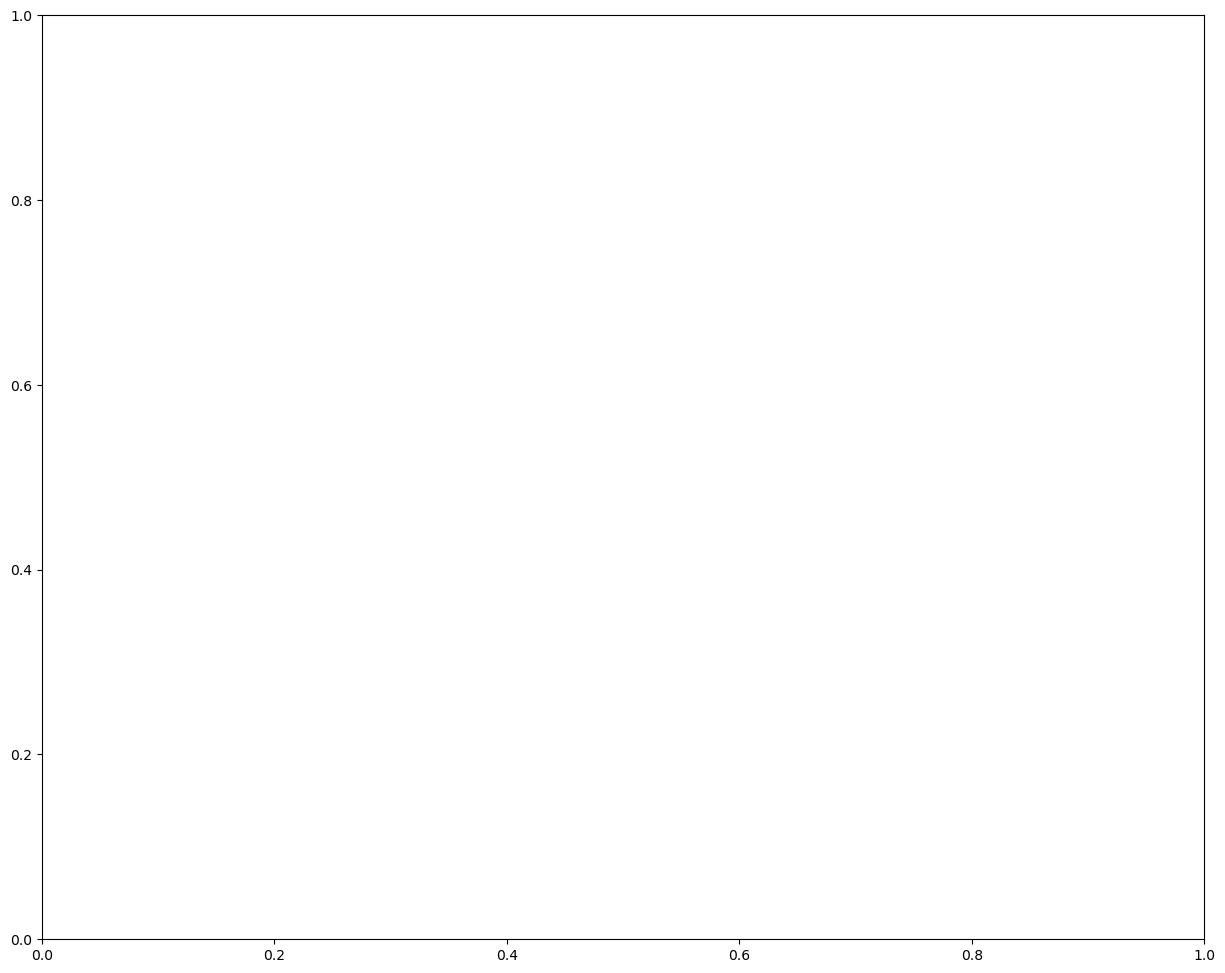

In [108]:
fig,ax1=plt.subplots(1, figsize=(15, 12))
show((GOV_50,1), cmap='RdYlGn_r',ax=ax1)
proj_shapefile2.plot(ax=ax1, facecolor='None', edgecolor='darkgreen', linewidth=1.5)
ax1.set_title('Deforestation 2030-2050, Governance Scenario', fontsize=14)


red_patch = mpatches.Patch(color='darkgreen', label='State Boundaries')
plt.legend(handles=[red_patch])

cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(),cmap='RdYlGn_r'), ax=ax1) 
m0=0            # colorbar min value
m4=1            # colorbar max value
m1=0.25              # colorbar mid value 1
m2=0.5  
m3=0.75# colorbar mid value 2
cbar.set_ticks([m0,m1,m2,m3,m4])
cbar.set_ticklabels(['Not territory','Forest' ,'Rivers/water bodies','Deforestation','No forest'])
ax1.axis('off')

plt.show()

In [109]:
#from rasterstats import zonal_stats
zs_BAU_18 = zonal_stats(proj_shapefile2, BAU_2D,
                           affine=BAU.meta['transform'],
                           categorical=True)
zs_BAU_18  #ignore -999 warning - NoData already seems to be accounted for... (no zeros)

/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.war

[{0: 902, 1: 105309, 2: 288, 3: 1304},
 {0: 203, 1: 38379, 2: 7574, 3: 16969},
 {0: 305, 1: 5231, 2: 1433, 3: 18491},
 {0: 99, 1: 526, 2: 167, 3: 3613},
 {0: 159, 1: 11916, 2: 3535, 3: 10409},
 {1: 9565, 2: 382, 3: 13450},
 {0: 86, 1: 7254, 2: 1185, 3: 16370},
 {1: 4506, 2: 540, 3: 2504},
 {1: 66987, 2: 10561, 3: 12579},
 {1: 6981, 2: 1066, 3: 36691},
 {0: 35, 1: 19555, 2: 1308, 3: 8266},
 {0: 12, 1: 7590, 2: 1317, 3: 13991},
 {0: 487, 1: 40546, 2: 2226, 3: 2000},
 {1: 10453, 2: 661, 3: 13323},
 {0: 318, 1: 66428, 2: 296, 3: 2559},
 {1: 46687, 2: 5974, 3: 3028},
 {1: 11328, 2: 706, 3: 8256},
 {0: 278, 1: 4770, 2: 767, 3: 15218},
 {0: 44, 1: 6042, 2: 1292, 3: 14156},
 {1: 30334, 2: 9054, 3: 46007},
 {0: 627, 1: 22947, 2: 1943, 3: 6481},
 {0: 134, 1: 12327, 2: 3564, 3: 6786},
 {0: 181, 1: 16476, 2: 5440, 3: 1941},
 {1: 926, 2: 211, 3: 585},
 {1: 2830, 2: 281, 3: 934},
 {25: 53},
 {1: 14774, 2: 2563, 3: 12946},
 {0: 81, 1: 2192, 2: 503, 3: 8045},
 {1: 10271, 2: 867, 3: 12255},
 {0: 93, 1:

In [110]:
zs_BAU_18_pd = pd.DataFrame(zs_BAU_18)
zs_BAU_18_pd.head()

0         1       2        3   25
0  902.0  105309.0   288.0   1304.0 NaN
1  203.0   38379.0  7574.0  16969.0 NaN
2  305.0    5231.0  1433.0  18491.0 NaN
3   99.0     526.0   167.0   3613.0 NaN
4  159.0   11916.0  3535.0  10409.0 NaN

In [111]:
zs_BAU_18_pd.set_index(proj_shapefile2.index,inplace=True)

In [112]:
zs_BAU_18_pd.rename(columns=lclabs,inplace=True)  #use the lclabs dict we created above
zs_BAU_18_pd = zs_BAU_18_pd.add_suffix('bau')
zs_BAU_18_pd.head()

Total Areabau  Forestbau  Deforestationbau  No Forestbau  25bau
0          902.0   105309.0             288.0        1304.0    NaN
1          203.0    38379.0            7574.0       16969.0    NaN
2          305.0     5231.0            1433.0       18491.0    NaN
3           99.0      526.0             167.0        3613.0    NaN
4          159.0    11916.0            3535.0       10409.0    NaN

In [113]:
BAU_gpd = pd.merge(proj_shapefile2, zs_BAU_18_pd, how='left', left_index=True, right_index=True)
BAU_gpd.head()

ID_0  ISO    NAME_0  ID_1     NAME_1        TYPE_1    ENGTYPE_1 NL_NAME_1  \
0    53  COL  Colombia     1   Amazonas     Comisaría  Commissiary      None   
1    53  COL  Colombia     2  Antioquia  Departamento   Department      None   
2    53  COL  Colombia     3     Arauca   Intendencia   Intendancy      None   
3    53  COL  Colombia     4  Atlántico  Departamento   Department      None   
4    53  COL  Colombia     5    Bolívar  Departamento   Department      None   

  VARNAME_1                                           geometry  Total Areabau  \
0      None  MULTIPOLYGON (((1120522.406 -119772.856, 11210...          902.0   
1      None  MULTIPOLYGON (((287954.897 908283.773, 287954....          203.0   
2      None  POLYGON ((976633.807 786015.945, 978900.205 78...          305.0   
3      None  POLYGON ((516638.218 1227916.258, 516638.234 1...           99.0   
4      None  MULTIPOLYGON (((426073.727 1123317.980, 426073...          159.0   

   Forestbau  Deforestationbau  No Forestbau  25bau  
0   105309.0             288.0        1304.0    NaN  
1    38379.0            7574.0       16969.0    NaN  
2     5231.0            1433.0       18491.0    NaN  
3      526.0             167.0        3613.0    NaN  
4    11916.0            3535.0       10409.0    NaN

<AxesSubplot: >

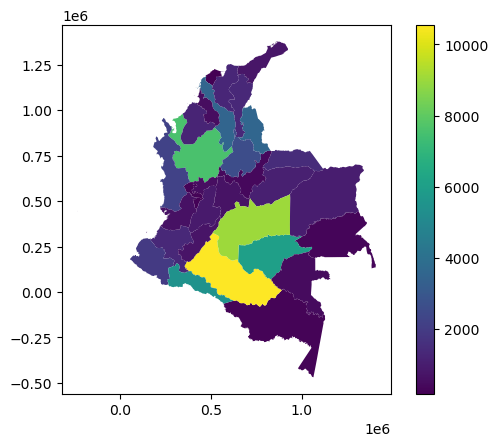

In [114]:
BAU_gpd.plot('Deforestationbau', legend = True)

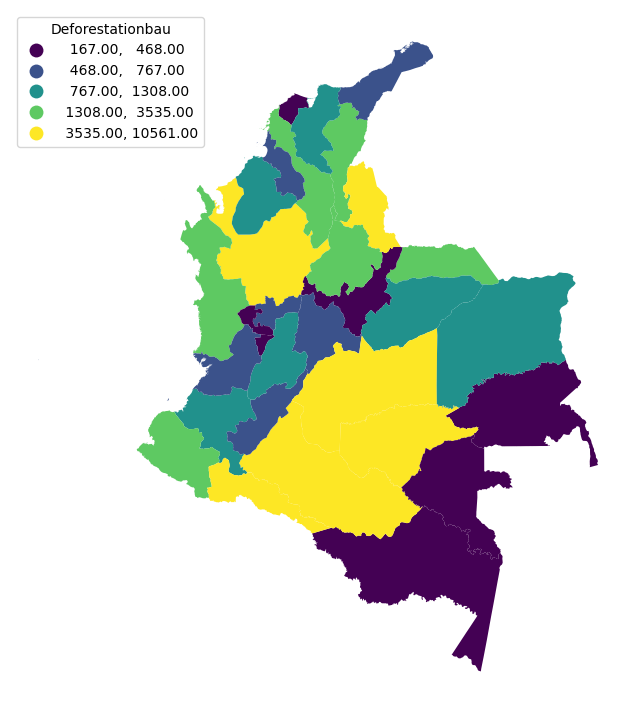

In [115]:
col = 'Deforestationbau'

fig, ax = plt.subplots(1, figsize=(9, 9))


BAU_gpd.plot(column=col, cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":col,"loc": 2},
        ax=ax
       )
ax.set_axis_off()

plt.show()

In [116]:
zs_GOV_18_6 = zonal_stats(proj_shapefile2, GOV_2D,
                           affine=GOV.meta['transform'],
                           categorical=True)

zs_GOV_18_6_pd = pd.DataFrame(zs_GOV_18_6)
zs_GOV_18_6_pd.set_index(proj_shapefile2.index,inplace=True)
zs_GOV_18_6_pd.rename(columns=lclabs,inplace=True)
zs_GOV_18_6_pd = zs_GOV_18_6_pd.add_suffix('gov')
BAUGOV18_gpd = BAU_gpd.join(zs_GOV_18_6_pd, how='left')

/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.war

In [117]:
BAUGOV18_gpd.columns

Index(['ID_0', 'ISO', 'NAME_0', 'ID_1', 'NAME_1', 'TYPE_1', 'ENGTYPE_1',
       'NL_NAME_1', 'VARNAME_1', 'geometry', 'Total Areabau', 'Forestbau',
       'Deforestationbau', 'No Forestbau', '25bau', 'Total Areagov',
       'Forestgov', 'Deforestationgov', 'No Forestgov', '25gov'],
      dtype='object')

In [118]:
BAUGOV18_gpd['Deforestationbau-gov'] = BAUGOV18_gpd['Deforestationbau'] - BAUGOV18_gpd['Deforestationgov']

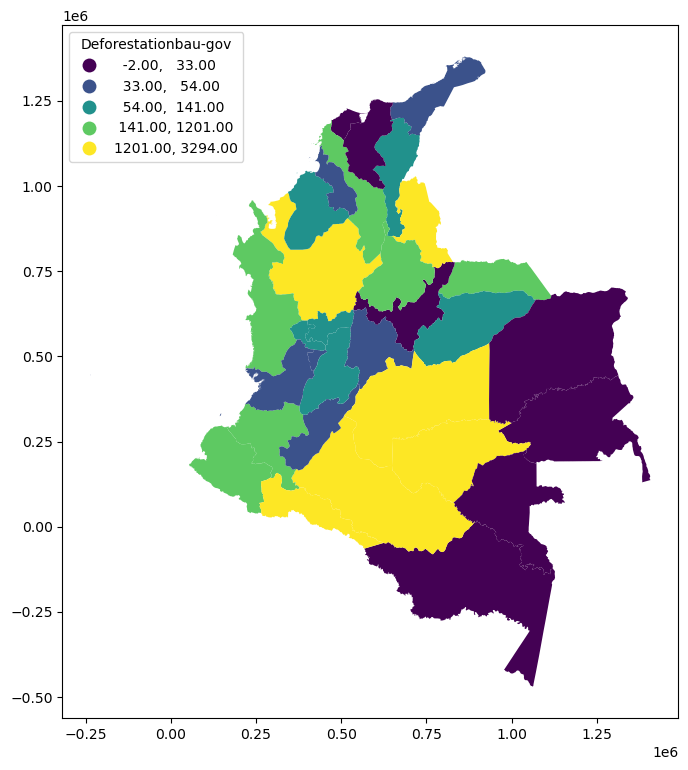

In [119]:
col='Deforestationbau-gov'

fig, ax = plt.subplots(1, figsize=(9, 9))

BAUGOV18_gpd.plot(column=col, cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":col,"loc": 2},
        ax=ax
       )

plt.show()

In [120]:
BAUGOV18_gpd['Sum18'] = BAUGOV18_gpd.loc[:,'Forestbau':'No Forestbau'].sum(axis=1)   #axis=1 to sum rows

In [121]:
BAUGOV18_gpd['Deforestation18Perc'] = 100* BAUGOV18_gpd['Deforestationbau-gov'] / BAUGOV18_gpd['Sum18']

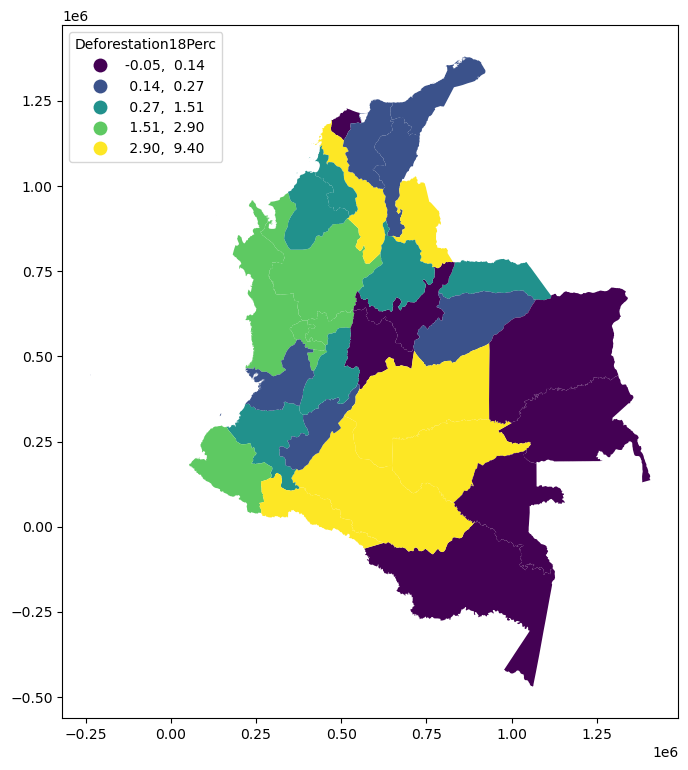

In [122]:
col='Deforestation18Perc'

fig, ax = plt.subplots(1, figsize=(9, 9))

BAUGOV18_gpd.plot(column=col, cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":col,"loc": 2},
        ax=ax
       )

plt.show()

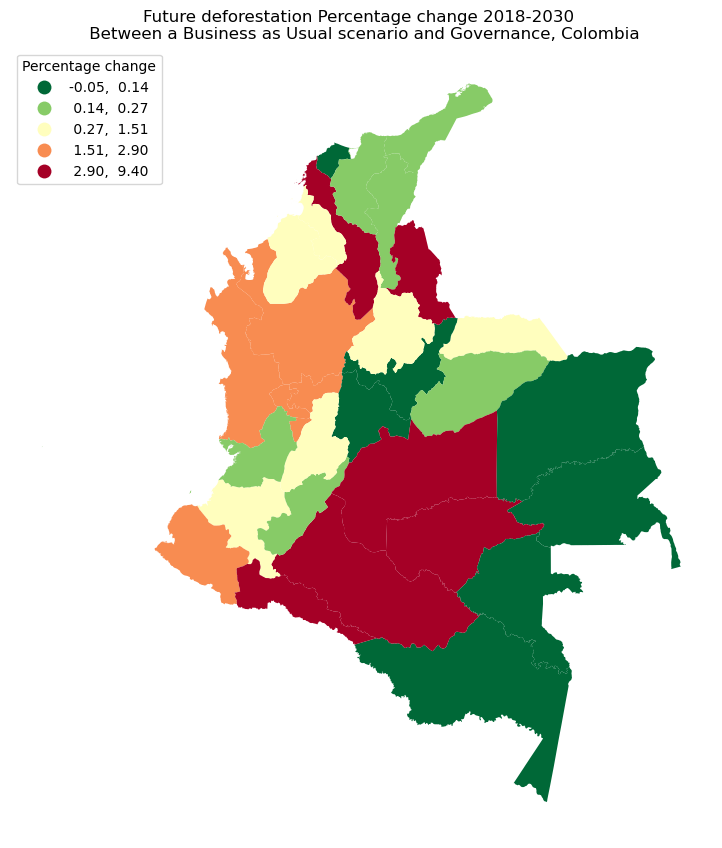

In [123]:
col='Deforestation18Perc'

fig, ax = plt.subplots(1, figsize=(9, 9))

BAUGOV18_gpd.plot(column=col, cmap='RdYlGn_r', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":'Percentage change',"loc": 2},
        ax=ax
       )


plt.title("Future deforestation Percentage change 2018-2030 \n Between a Business as Usual scenario and Governance, Colombia")
fig.tight_layout()

ax.axis('off')

plt.savefig('percentage')
plt.show()

In [124]:
proj_Densidad = Densidad.to_crs({'init':'EPSG:32618'})


/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


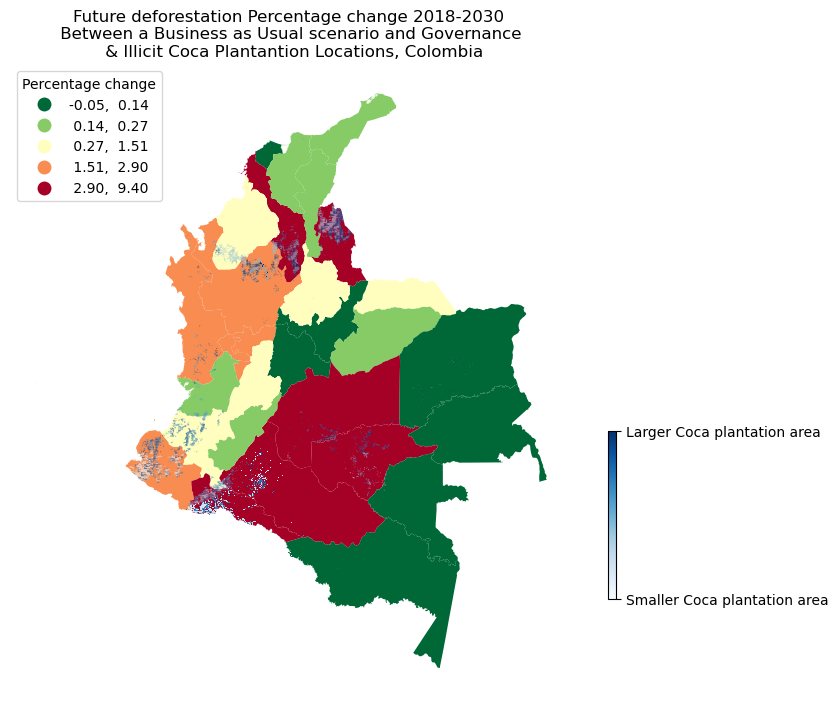

In [125]:
col='Deforestation18Perc'

fig, ax = plt.subplots(1, figsize=(9, 9))

BAUGOV18_gpd.plot(column=col, cmap='RdYlGn_r', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":'Percentage change',"loc": 2},
        ax=ax
       )
proj_Densidad.plot(cmap='Blues', ax=ax)

cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(),cmap='Blues'), ax=ax, anchor=(0, 0.3), shrink=0.2) 
m0=0            # colorbar min value
m4=1            # colorbar max value            # colorbar mid value 1
 
cbar.set_ticks([m0,m4])
cbar.set_ticklabels(['Smaller Coca plantation area', 'Larger Coca plantation area'])
ax1.axis('off')

plt.title("Future deforestation Percentage change 2018-2030 \n Between a Business as Usual scenario and Governance \n & Illicit Coca Plantantion Locations, Colombia")
fig.tight_layout()

ax.axis('off')

plt.savefig('percentageandcoca18.png')

plt.show()



In [126]:
zs_BAU_50 = zonal_stats(proj_shapefile2, BAU_50_2D,
                           affine=BAU_50.meta['transform'],
                           categorical=True)

zs_BAU_50_pd = pd.DataFrame(zs_BAU_50)
zs_BAU_50_pd.set_index(proj_shapefile2.index,inplace=True)
zs_BAU_50_pd.rename(columns=lclabs,inplace=True)
zs_BAU_50_pd = zs_BAU_50_pd.add_suffix('bau')

/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.war

In [127]:
BAU50_gpd = pd.merge(proj_shapefile2, zs_BAU_50_pd, how='left', left_index=True, right_index=True)
BAU50_gpd.head()

ID_0  ISO    NAME_0  ID_1     NAME_1        TYPE_1    ENGTYPE_1 NL_NAME_1  \
0    53  COL  Colombia     1   Amazonas     Comisaría  Commissiary      None   
1    53  COL  Colombia     2  Antioquia  Departamento   Department      None   
2    53  COL  Colombia     3     Arauca   Intendencia   Intendancy      None   
3    53  COL  Colombia     4  Atlántico  Departamento   Department      None   
4    53  COL  Colombia     5    Bolívar  Departamento   Department      None   

  VARNAME_1                                           geometry  Total Areabau  \
0      None  MULTIPOLYGON (((1120522.406 -119772.856, 11210...          902.0   
1      None  MULTIPOLYGON (((287954.897 908283.773, 287954....          203.0   
2      None  POLYGON ((976633.807 786015.945, 978900.205 78...          305.0   
3      None  POLYGON ((516638.218 1227916.258, 516638.234 1...           99.0   
4      None  MULTIPOLYGON (((426073.727 1123317.980, 426073...          159.0   

   Forestbau  Deforestationbau  No Forestbau  25bau  
0   105270.0             327.0        1304.0    NaN  
1    34581.0           11372.0       16969.0    NaN  
2     4384.0            2280.0       18491.0    NaN  
3      522.0             171.0        3613.0    NaN  
4     9190.0            6261.0       10409.0    NaN

In [128]:
zs_GOV_50 = zonal_stats(proj_shapefile2, GOV_50_2D,
                           affine=GOV.meta['transform'],
                           categorical=True)

zs_GOV_50_pd = pd.DataFrame(zs_GOV_50)
zs_GOV_50_pd.set_index(proj_shapefile2.index,inplace=True)
zs_GOV_50_pd.rename(columns=lclabs,inplace=True)
zs_GOV_50_pd = zs_GOV_50_pd.add_suffix('gov')
BAUGOV50_gpd = BAU50_gpd.join(zs_GOV_50_pd, how='left')

/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/opt/anaconda3/envs/sds2022/lib/python3.9/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.war

In [129]:
BAUGOV50_gpd.columns

Index(['ID_0', 'ISO', 'NAME_0', 'ID_1', 'NAME_1', 'TYPE_1', 'ENGTYPE_1',
       'NL_NAME_1', 'VARNAME_1', 'geometry', 'Total Areabau', 'Forestbau',
       'Deforestationbau', 'No Forestbau', '25bau', 'Total Areagov',
       'Forestgov', 'Deforestationgov', 'No Forestgov', '25gov'],
      dtype='object')

In [130]:
BAUGOV50_gpd['Deforestationbau-gov'] = BAUGOV50_gpd['Deforestationbau'] - BAUGOV50_gpd['Deforestationgov']

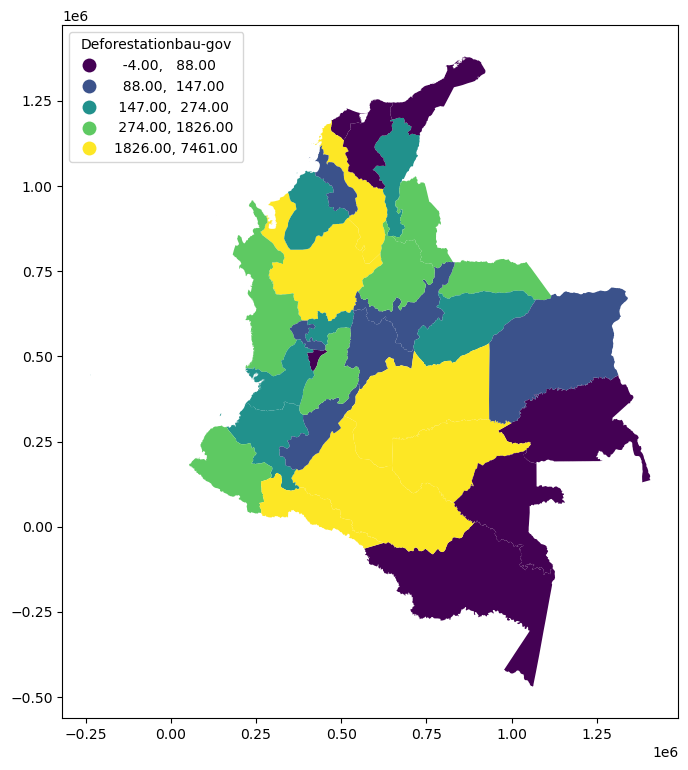

In [131]:
col='Deforestationbau-gov'

fig, ax = plt.subplots(1, figsize=(9, 9))

BAUGOV50_gpd.plot(column=col, cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":col,"loc": 2},
        ax=ax
       )

plt.show()

In [132]:
BAUGOV50_gpd['Sum50'] = BAUGOV50_gpd.loc[:,'Forestbau':'No Forestbau'].sum(axis=1)   #axis=1 to sum rows

In [133]:
BAUGOV50_gpd['Deforestation50Perc'] = 100* BAUGOV50_gpd['Deforestationbau-gov'] / BAUGOV50_gpd['Sum50']

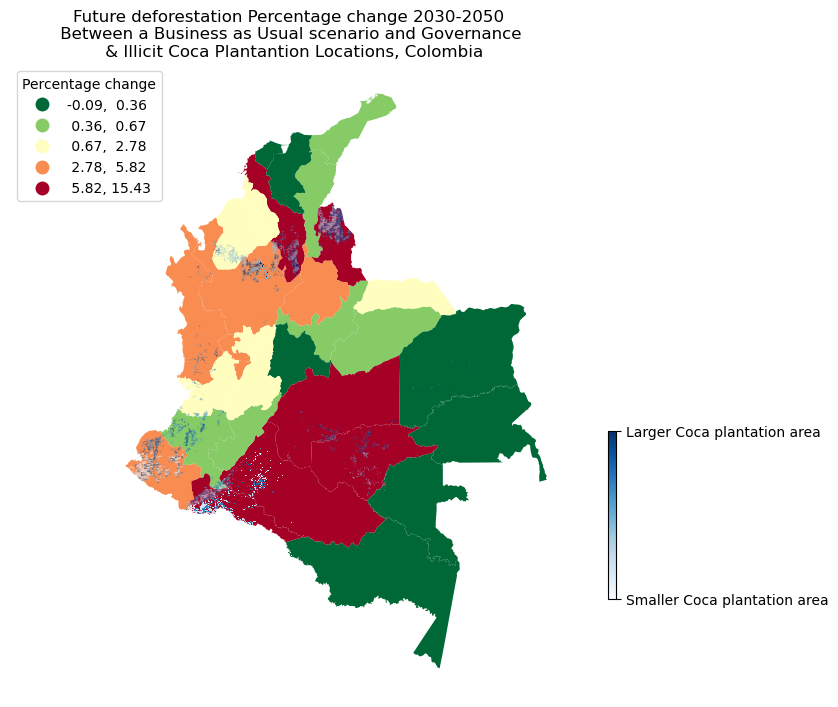

In [134]:
col='Deforestation50Perc'

fig, ax = plt.subplots(1, figsize=(9, 9))

BAUGOV50_gpd.plot(column=col, cmap='RdYlGn_r', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":"Percentage change","loc": 2},
        ax=ax
       )
proj_Densidad.plot(cmap='Blues', ax=ax)

cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(),cmap='Blues'), ax=ax, anchor=(0, 0.3), shrink=0.2) 
m0=0            # colorbar min value
m4=1            # colorbar max value            # colorbar mid value 1  
cbar.set_ticks([m0,m4])
cbar.set_ticklabels(['Smaller Coca plantation area', 'Larger Coca plantation area'])
ax1.axis('off')

plt.title("Future deforestation Percentage change 2030-2050 \n Between a Business as Usual scenario and Governance \n & Illicit Coca Plantantion Locations, Colombia")
fig.tight_layout()

ax.axis('off')

plt.savefig('percentageandcoca50.png')

plt.show()



NameError: name 'woodcmap' is not defined

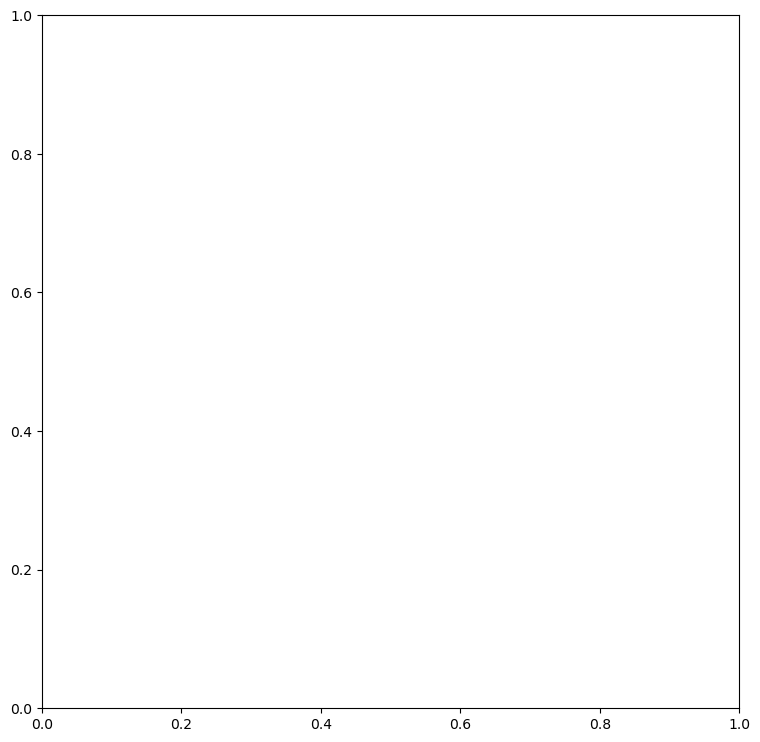

In [139]:
col='Deforestation50Perc'

fig, ax = plt.subplots(1, figsize=(9, 9))

BAUGOV50_gpd.plot(column=col, cmap= woodcmap, 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":col,"loc": 2},
        ax=ax
       )
proj_Densidad.plot(cmap='Blues', ax=ax)

cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(),cmap='Blues'), ax=ax, anchor=(0, 0.3), shrink=0.2) 
m0=0            # colorbar min value
m4=1            # colorbar max value            # colorbar mid value 1  
cbar.set_ticks([m0,m4])
cbar.set_ticklabels(['Smaller Coca plantation area', 'Larger Coca plantation area'])
ax1.axis('off')

plt.title("Future deforestation Percentage change 2030-2050 \n Between a Business as Usual scenario and Governance \n & Illicit Coca Plantantion Locations, Colombia")
fig.tight_layout()

ax.axis('off')

plt.savefig('percentageandcoca50.png')

plt.show()



count    31.000000
mean      1.665748
std       2.162072
min      -0.046447
25%       0.158688
50%       0.512974
75%       2.419105
max       9.397661
Name: Deforestation18Perc, dtype: float64


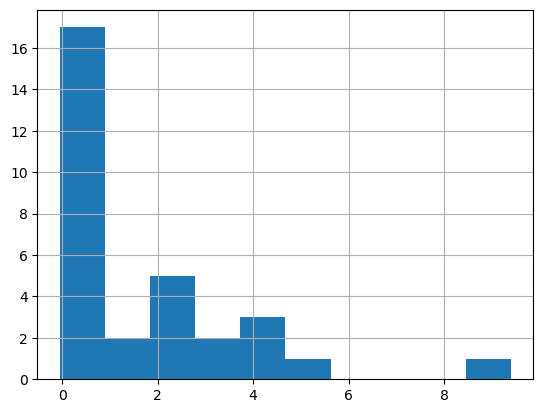

In [140]:
BAUGOV18_gpd['Deforestation18Perc'].hist()
print(BAUGOV18_gpd['Deforestation18Perc'].describe())

count    31.000000
mean      3.234913
std       3.995240
min      -0.092894
25%       0.413887
50%       1.104438
75%       5.268051
max      15.429434
Name: Deforestation50Perc, dtype: float64


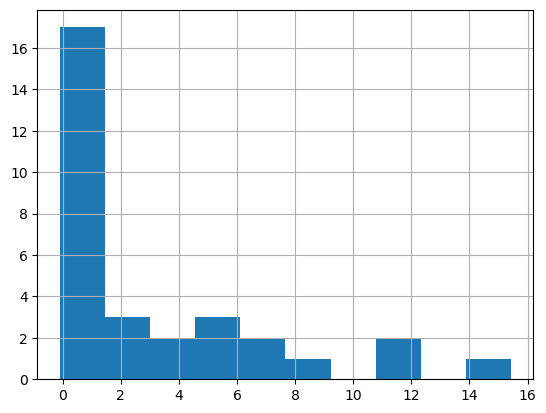

In [141]:
BAUGOV50_gpd['Deforestation50Perc'].hist()
print(BAUGOV50_gpd['Deforestation50Perc'].describe())

In [142]:

woodbins1 = [0,2,4,6,8,10,12]
woodbins2 = [0,2,6,8,12,16]

woodcolors = ["#de77ae","#f1b6da", "#fde0ef", "#e6f5d0", "#b8e186", "#7fbc41"] 
woodcolors.reverse()
redcolors = ['firebrick', 'tomato', 'orange', 'navajowhite', 'honeydew','lightgreen', 'green']
redcolors2= ['#a50026','#ea593a','#fdbf6f','#ffffbf','#b7e075','#4db15d','#006837']
redcolors.reverse()
redcolors2.reverse()
woodcmap = ListedColormap(woodcolors)
redcmap = ListedColormap('RdYlGn_r')

In [143]:
cmap = cm.get_cmap('RdYlGn', 7)  # matplotlib color palette name, n colors
for i in range(cmap.N):
    rgb = cmap(i)[:7]  # will return rgba, we take only first 3 so we get rgb
    print(matplotlib.colors.rgb2hex(rgb))


#a50026
#ea593a
#fdbf6f
#ffffbf
#b7e075
#4db15d
#006837


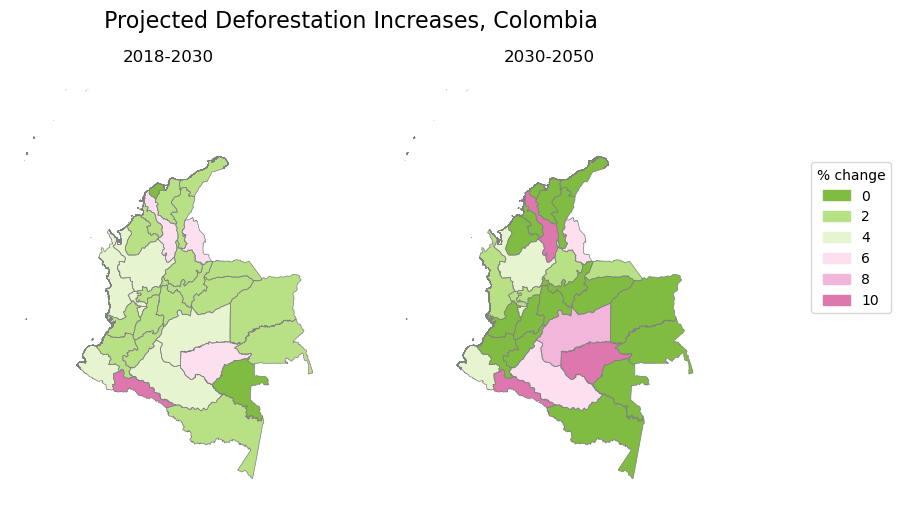

In [144]:
fig, axes = plt.subplots(1,2, figsize=(9, 9))

BAUGOV18_gpd.plot(column='Deforestation18Perc', 
    cmap=woodcmap, 
    scheme='UserDefined', 
    classification_kwds={'bins': woodbins1},
    legend=False, ax=axes[0]
)

BAUGOV50_gpd.plot(column='Deforestation50Perc', 
    cmap=woodcmap, 
    scheme='UserDefined', 
    classification_kwds={'bins': woodbins1},
    legend=False, ax=axes[1]
)

BAUGOV18_gpd.plot(ax=axes[0], facecolor='None', edgecolor='grey', linewidth=0.5)
BAUGOV50_gpd.plot(ax=axes[1], facecolor='None', edgecolor='grey', linewidth=0.5)

axes[0].set_axis_off()
axes[1].set_axis_off()

axes[0].set_title('2018-2030')
axes[1].set_title('2030-2050')

# use zip to combine two lists into a dict
legend_wood1 = dict(zip(woodcolors, woodbins1))
legend_wood2 = dict(zip(woodcolors, woodbins1))

#from matplotlib.patches import Patch
patches = [Patch(color=color, label=label)
           for color, label in legend_wood1.items()]

#add legend!
axes[1].legend(handles=patches,
        bbox_to_anchor=(1.6, 0.8),
        facecolor="white",
        title='% change')

plt.suptitle(" Projected Deforestation Increases, Colombia", size=16, y=0.8)

plt.savefig('Deforestation_increases_Colombia.png')
plt.show()

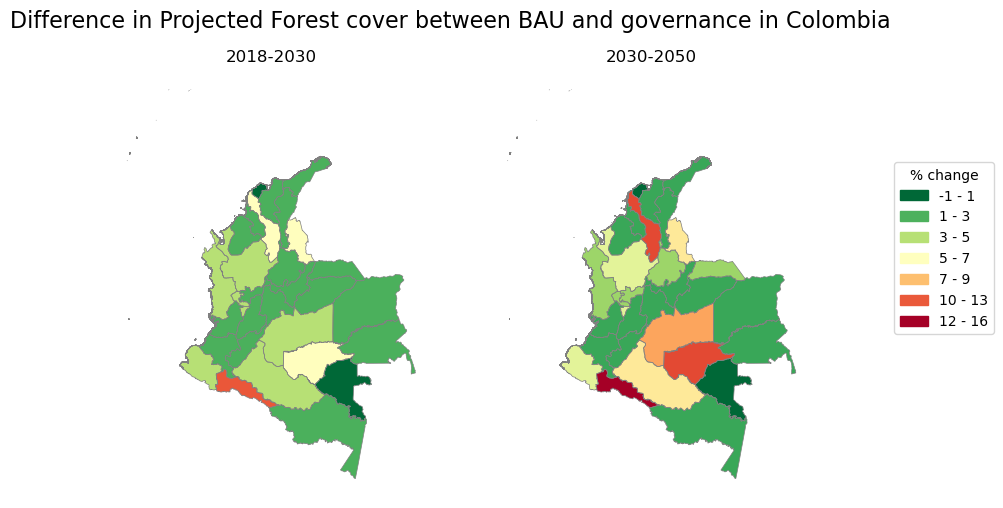

In [145]:
fig, axes = plt.subplots(1,2, figsize=(9, 9))

BAUGOV18_gpd.plot(column='Deforestation18Perc', 
    cmap='RdYlGn_r', 
    scheme='UserDefined', 
    classification_kwds={'bins': woodbins1},
    legend=False, ax=axes[0]
)

BAUGOV50_gpd.plot(column='Deforestation50Perc', 
    cmap='RdYlGn_r', 
    scheme='UserDefined', 
    classification_kwds={'bins': woodbins1},
    legend=False, ax=axes[1]
)

BAUGOV18_gpd.plot(ax=axes[0], facecolor='None', edgecolor='grey', linewidth=0.5)
BAUGOV50_gpd.plot(ax=axes[1], facecolor='None', edgecolor='grey', linewidth=0.5)

axes[0].set_axis_off()
axes[1].set_axis_off()

axes[0].set_title('2018-2030')
axes[1].set_title('2030-2050')

# use zip to combine two lists into a dict
legend_red1 = dict(zip(redcolors2, woodbins1))

#from matplotlib.patches import Patch
patches = [Patch(color=color, label=label)
           for color, label in legend_red1.items()]

#add legend!
axes[1].legend(handles=patches,
        bbox_to_anchor=(1.6, 0.8),
        facecolor="white",
        title='% change')

leg = axes[1].get_legend()
leg.get_texts()[0].set_text('-1 - 1')
leg.get_texts()[1].set_text('1 - 3')
leg.get_texts()[2].set_text('3 - 5')
leg.get_texts()[3].set_text('5 - 7')
leg.get_texts()[4].set_text('7 - 9')
leg.get_texts()[5].set_text('10 - 13')
leg.get_texts()[6].set_text('12 - 16')


plt.suptitle("Difference in Projected Forest cover between BAU and governance in Colombia", size=16, y=0.8)

plt.savefig('samplefigurezxxsaasx.png', bbox_inches='tight')
plt.show()


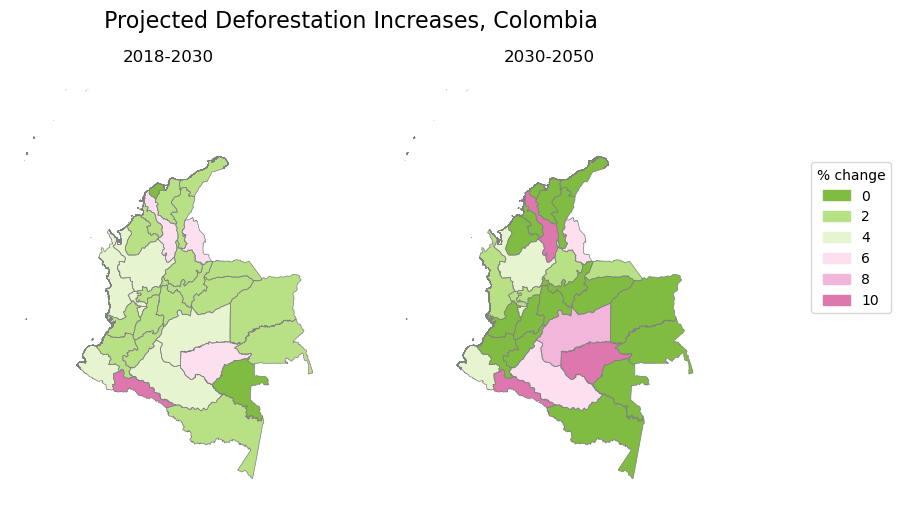

In [149]:
fig, axes = plt.subplots(1,2, figsize=(9, 9))

BAUGOV18_gpd.plot(column='Deforestation18Perc', 
    cmap=woodcmap, 
    scheme='UserDefined', 
    classification_kwds={'bins': woodbins1},
    legend=False, ax=axes[0]
)

BAUGOV50_gpd.plot(column='Deforestation50Perc', 
    cmap=woodcmap, 
    scheme='UserDefined', 
    classification_kwds={'bins': woodbins1},
    legend=False, ax=axes[1]
)

BAUGOV18_gpd.plot(ax=axes[0], facecolor='None', edgecolor='grey', linewidth=0.5)
BAUGOV50_gpd.plot(ax=axes[1], facecolor='None', edgecolor='grey', linewidth=0.5)

axes[0].set_axis_off()
axes[1].set_axis_off()

axes[0].set_title('2018-2030')
axes[1].set_title('2030-2050')

# use zip to combine two lists into a dict
legend_wood = dict(zip(woodcolors, woodbins1))

#from matplotlib.patches import Patch
patches = [Patch(color=color, label=label)
           for color, label in legend_wood.items()]

#add legend!
axes[1].legend(handles=patches,
        bbox_to_anchor=(1.6, 0.8),
        facecolor="white",
        title='% change')

plt.suptitle(" Projected Deforestation Increases, Colombia", size=16, y=0.8)

plt.savefig('samplefigure.png', bbox_inches='tight')
plt.show()


In [150]:
BAU_f = BAU_2D.flatten()  #flatten from 2d to 1D
GOV_f = GOV_2D.flatten()  #flatten from 2d to 1D

print(BAU_f.shape)
print(GOV_f.shape)

(2598388,)
(2598388,)


In [151]:
confND = metrics.confusion_matrix(GOV_f, BAU_f)
print(confND.shape)
print('\n')
print(confND)

(4, 4)


[[1459412       0       0       0]
 [      0  693438   20596       0]
 [      0    1500   47268       0]
 [      0       0       0  376174]]


In [152]:
def stripFirstRows(mydat):
    
    stripped = np.delete(arr=mydat, obj=0, axis=0)     #delete 0-th row
    stripped = np.delete(arr=stripped, obj=0, axis=1)  #delete 0-th col
    
    return stripped

In [153]:
conf = stripFirstRows(confND)

print(conf.shape)
print('\n')
print(conf)

(3, 3)


[[693438  20596      0]
 [  1500  47268      0]
 [     0      0 376174]]


In [154]:
conf_pd = pd.DataFrame(conf,index=lc6_names[1:],columns=lc6_names[1:])
conf_pd

Forest  Deforestation  No Forest
Forest         693438          20596          0
Deforestation    1500          47268          0
No Forest           0              0     376174

In [155]:
sourcelc = []
for i in range(0, 3):
    sourcelc += [i] * 3
print(sourcelc)

[0, 0, 0, 1, 1, 1, 2, 2, 2]


In [156]:
targetlc = list(range(0,3))
targetlc *= 3
print(targetlc)

[0, 1, 2, 0, 1, 2, 0, 1, 2]


In [157]:
conf_list = conf.flatten().tolist()  #conf from above!
print(conf_list)

[693438, 20596, 0, 1500, 47268, 0, 0, 0, 376174]


In [158]:
linkslc = dict(source = sourcelc, target = targetlc, value = conf_list)
print(linkslc)

{'source': [0, 0, 0, 1, 1, 1, 2, 2, 2], 'target': [0, 1, 2, 0, 1, 2, 0, 1, 2], 'value': [693438, 20596, 0, 1500, 47268, 0, 0, 0, 376174]}


In [159]:
targetlc2 = list(range(3,6))
targetlc2 *= 3
print(targetlc2)

[3, 4, 5, 3, 4, 5, 3, 4, 5]


In [160]:
linkslc2 = dict(source = sourcelc, target = targetlc2, value = conf_list)
print(linkslc2)

{'source': [0, 0, 0, 1, 1, 1, 2, 2, 2], 'target': [3, 4, 5, 3, 4, 5, 3, 4, 5], 'value': [693438, 20596, 0, 1500, 47268, 0, 0, 0, 376174]}


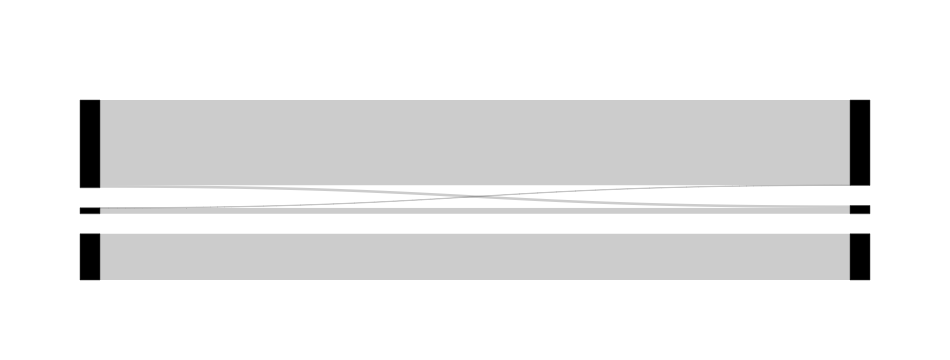

In [161]:
datalc2 = go.Sankey(link = linkslc2)
fig = go.Figure(datalc2)

fig.show()

In [162]:
slabels = lc6_names[1:] + lc6_names[1:]  #[1:] because we removed No Data
slabels 

['Forest',
 'Deforestation',
 'No Forest',
 'Forest',
 'Deforestation',
 'No Forest']

In [163]:
scolors =  ['darkseagreen', 'honeydew', 'lightsalmon', 'darkseagreen', 'honeydew', 'lightsalmon']  #[1:] because we removed No Data
scolors

['darkseagreen',
 'honeydew',
 'lightsalmon',
 'darkseagreen',
 'honeydew',
 'lightsalmon']

In [164]:
nodelc = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = slabels ,     
      color = scolors
    )

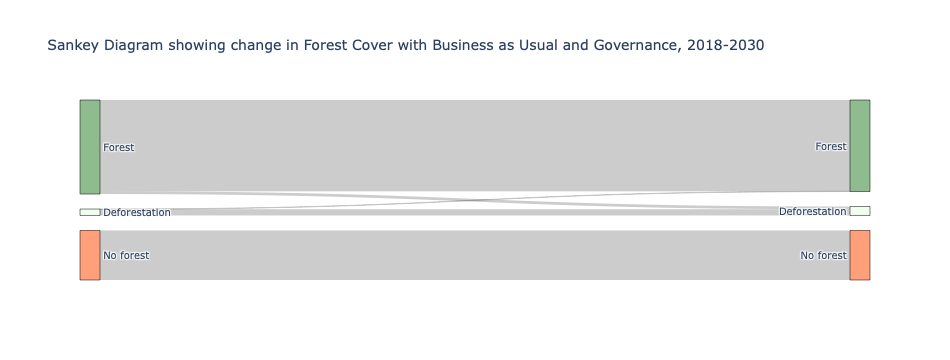

In [165]:
datalc2 = go.Sankey(node= dict(nodelc, label = ["Forest", "Deforestation", "No forest", "Forest", "Deforestation", "No forest"]),link = linkslc2)
fig = go.Figure(datalc2)

fig.update_layout(title_text= "Sankey Diagram showing change in Forest Cover with Business as Usual and Governance, 2018-2030",
                  font_size=10)

fig.show()

In [166]:
BAU_50_f = BAU_50_2D.flatten()  #flatten from 2d to 1D
GOV_50_f = GOV_50_2D.flatten()  #flatten from 2d to 1D

print(BAU_50_f.shape)
print(GOV_50_f.shape)

(2598388,)
(2598388,)


In [167]:
confND = metrics.confusion_matrix(GOV_50_f, BAU_50_f)
print(confND.shape)
print('\n')
print(confND)

(4, 4)


[[1459412       0       0       0]
 [      0  652277   40696       0]
 [      0    2117   67712       0]
 [      0       0       0  376174]]


In [168]:
def stripFirstRows(mydat):
    
    stripped = np.delete(arr=mydat, obj=0, axis=0)     #delete 0-th row
    stripped = np.delete(arr=stripped, obj=0, axis=1)  #delete 0-th col
    
    return stripped

In [169]:
conf = stripFirstRows(confND)

print(conf.shape)
print('\n')
print(conf)

(3, 3)


[[652277  40696      0]
 [  2117  67712      0]
 [     0      0 376174]]


In [170]:
conf_pd = pd.DataFrame(conf,index=lc6_names[1:],columns=lc6_names[1:])
conf_pd

Forest  Deforestation  No Forest
Forest         652277          40696          0
Deforestation    2117          67712          0
No Forest           0              0     376174

In [171]:
sourcelc = []
for i in range(0, 3):
    sourcelc += [i] * 3
print(sourcelc)

[0, 0, 0, 1, 1, 1, 2, 2, 2]


In [172]:
targetlc = list(range(0,3))
targetlc *= 3
print(targetlc)

[0, 1, 2, 0, 1, 2, 0, 1, 2]


In [173]:
conf_list = conf.flatten().tolist()  #conf from above!
print(conf_list)

[652277, 40696, 0, 2117, 67712, 0, 0, 0, 376174]


In [174]:
linkslc = dict(source = sourcelc, target = targetlc, value = conf_list)
print(linkslc)

{'source': [0, 0, 0, 1, 1, 1, 2, 2, 2], 'target': [0, 1, 2, 0, 1, 2, 0, 1, 2], 'value': [652277, 40696, 0, 2117, 67712, 0, 0, 0, 376174]}


In [175]:
linkslc2 = dict(source = sourcelc, target = targetlc2, value = conf_list)
print(linkslc2)

{'source': [0, 0, 0, 1, 1, 1, 2, 2, 2], 'target': [3, 4, 5, 3, 4, 5, 3, 4, 5], 'value': [652277, 40696, 0, 2117, 67712, 0, 0, 0, 376174]}


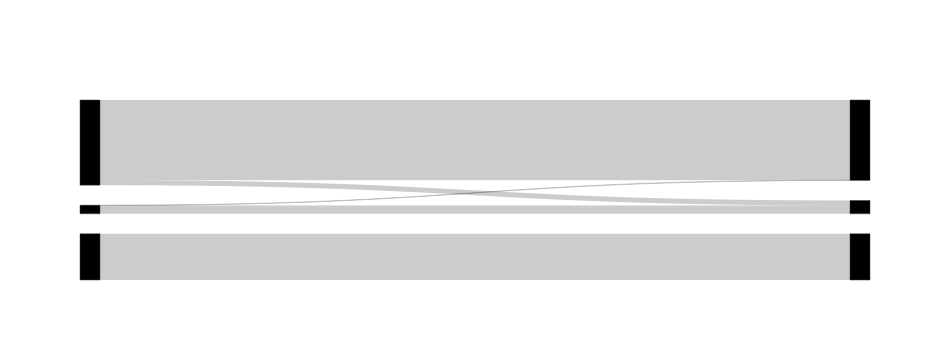

In [176]:
datalc2 = go.Sankey(link = linkslc2)
fig = go.Figure(datalc2)

fig.show()

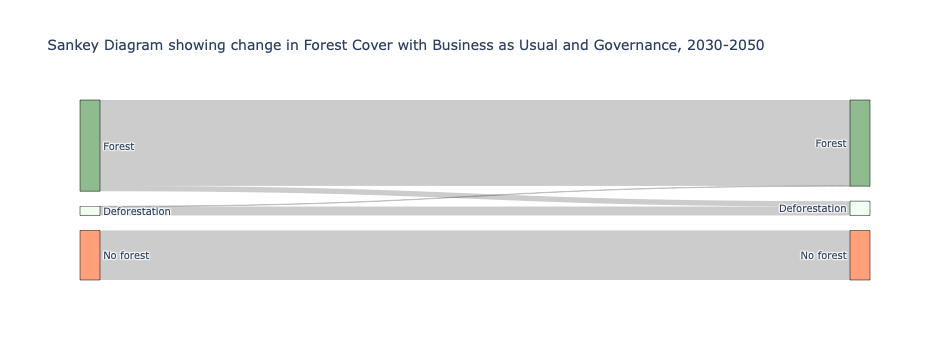

In [177]:
datalc2 = go.Sankey(node= dict(nodelc, label = ["Forest", "Deforestation", "No forest", "Forest", "Deforestation", "No forest"]),link = linkslc2)
fig = go.Figure(datalc2)

fig.update_layout(title_text= "Sankey Diagram showing change in Forest Cover with Business as Usual and Governance, 2030-2050",
                  font_size=10)

fig.show()

In [178]:
shapefile_cobertura = gpd.read_file('Cobertura_tierra_2000_2002/shape/cobertura_tierra2000_2002V2.shp')

In [179]:
shapefile_cobertura = shapefile_cobertura.set_geometry('geometry')

In [180]:
shapefile_cobertura.head()

CODIGO                                        NIVEL3  \
0     323  3.2.3. Vegetacion secundaria o en transicion   
1     323  3.2.3. Vegetacion secundaria o en transicion   
2     323  3.2.3. Vegetacion secundaria o en transicion   
3     323  3.2.3. Vegetacion secundaria o en transicion   
4     323  3.2.3. Vegetacion secundaria o en transicion   

                                        LEYENDA  Shape_Area  RULEID  \
0  3.2.3. Vegetacion secundaria o en transicion    0.000499      37   
1  3.2.3. Vegetacion secundaria o en transicion    0.000089      37   
2  3.2.3. Vegetacion secundaria o en transicion    0.000057      37   
3  3.2.3. Vegetacion secundaria o en transicion    0.000035      37   
4  3.2.3. Vegetacion secundaria o en transicion    0.000024      37   

                                            geometry  
0  POLYGON ((-74.22698 -0.49700, -74.22696 -0.497...  
1  POLYGON ((-74.29661 -0.42893, -74.29648 -0.429...  
2  POLYGON ((-74.51190 -0.36168, -74.51204 -0.361...  
3  POLYGON ((-74.56433 -0.32067, -74.56426 -0.320...  
4  POLYGON ((-74.48773 -0.31489, -74.48826 -0.315...

<AxesSubplot: >

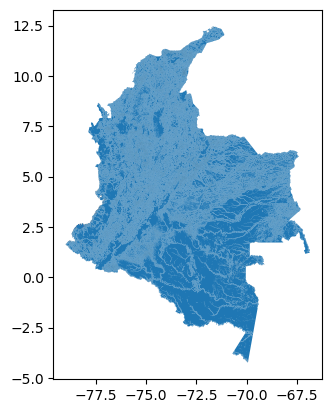

In [181]:
shapefile_cobertura.plot()

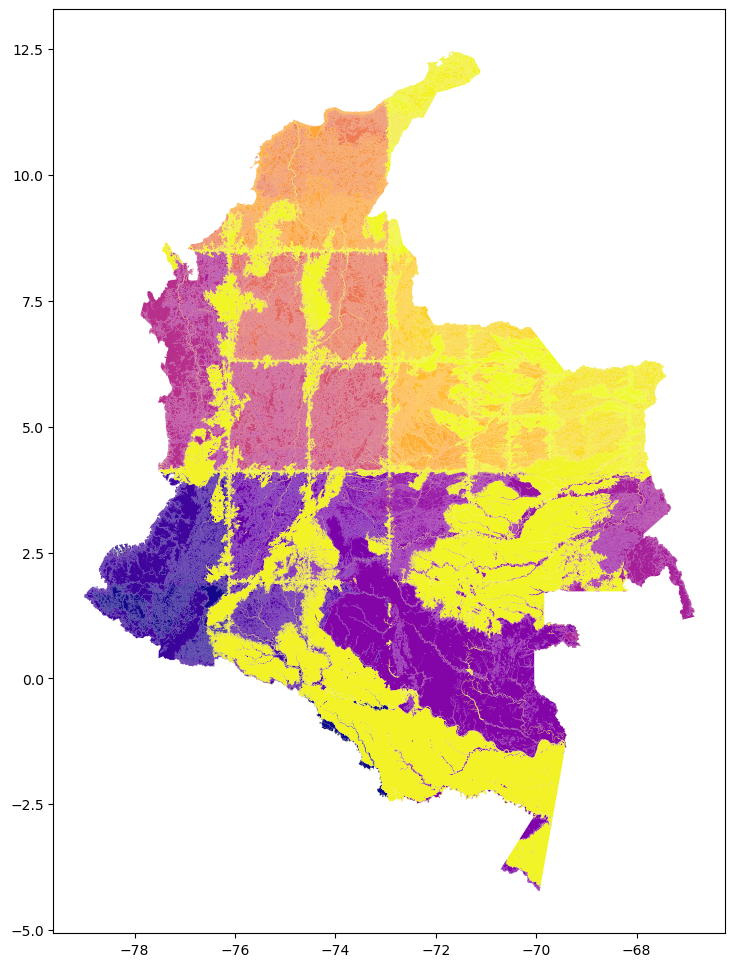

In [182]:
fig,ax1=plt.subplots(1, figsize=(15, 12))
shapefile_cobertura.plot(cmap='plasma',ax=ax1)


plt.show()